In [1]:
import sqlite3
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import MathsUtilities as MUte
import matplotlib.patheffects as path_effects
import GraphHelpers as GH
%matplotlib inline

### Link to APSIM output Data

In [2]:
con = sqlite3.connect(r'C:\Users\cflhxb\Dropbox\APSIMPotato\PotatoMod.db')

### Read the Simulations table that has SimulationID matched to Simulation Name

In [3]:
Simulations = pd.read_sql("Select * from _Simulations",
                                con)
Simulations.set_index('ID',inplace=True)

### Read in the Factor table that links factor names and levels to simulation IDs

In [4]:
Factors = pd.read_sql("Select * from _Factors",
                        con)
Factors.set_index('SimulationID',inplace=True)

### Read in the Report generated on the Sowing Event

In [5]:
LocList = pd.read_excel(r'C:\Users\cflhxb\Dropbox\APSIMPotato\List of locations.xlsx',engine="openpyxl")
LocList.set_index('metfile',inplace=True)

In [6]:
import re
def extractLocation(lcn):
    lcn = lcn.replace('MET files\\','')
    lcn = re.sub('\d','',lcn)
    lcn = lcn.replace('.met','')
    return lcn
def extractfileName(fn):
    fn = fn.replace('MET files\\','')
    fn = fn.replace('.met','')
    return fn

In [7]:
Obs = pd.read_excel(r'C:\Users\cflhxb\Dropbox\APSIMPotato\Observed.xlsx',engine="openpyxl")


In [8]:
InitialReport = pd.read_sql("Select * from InitialReport",
                        con)
InitialReport.loc[:,'SimulationName'] = [Simulations.loc[InitialReport.loc[x,'SimulationID'],'Name'] for x in InitialReport.index]
InitialReport.drop(['CheckpointID','Zone','Nitrogen','01','1','Field_','_','Water','Radiation','PlantDensity'],axis=1,inplace=True)
InitialReport.set_index('SimulationID',inplace=True)
InitialReport.loc[:,'Location'] = [extractLocation(x) for x in InitialReport.loc[:,'Weather.FileName']]
InitialReport.loc[:,'FileName'] = [extractfileName(InitialReport.loc[x,'Weather.FileName']) for x in InitialReport.index]
InitialReport.loc[:,'Country'] = [LocList.loc[x,'country'] for x in InitialReport.loc[:,'FileName']]
InitialReport.loc[:,'Loc'] = [LocList.loc[x,'loc'] for x in InitialReport.loc[:,'FileName']]
InitialReport.loc[:,'Country Loc'] = [InitialReport.loc[x,'Country'] + ' ' + InitialReport.loc[x,'Loc'] for x in InitialReport.index] 

In [9]:
DailyReport = pd.read_sql("Select * from DailyReport",
                        con)
DailyReport.loc[:,'SimulationName'] = [Simulations.loc[DailyReport.loc[x,'SimulationID'],'Name'] for x in DailyReport.index]
DailyReport.drop(['CheckpointID','Zone','Nitrogen','01','1','Field_','_','Water','Radiation','PlantDensity'],axis=1,inplace=True)
DailyReport.set_index('SimulationID',inplace=True)

In [10]:
DailyPreObs = pd.read_sql("Select * from TimeSeriesData",
                        con)
DailyPreObs.loc[:,'SimulationName'] = [Simulations.loc[DailyPreObs.loc[x,'SimulationID'],'Name'] for x in DailyPreObs.index]
DailyPreObs.set_index('SimulationID',inplace=True)
DailyPreObs.drop_duplicates(inplace=True)
DailyReport.loc[:,'Clock.Today'] = pd.to_datetime(DailyReport.loc[:,'Clock.Today'])

C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_13052\3386172286.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  DailyReport.loc[:,'Clock.Today'] = pd.to_datetime(DailyReport.loc[:,'Clock.Today'])


In [11]:
HarvestReport = pd.read_sql("Select * from HarvestReport",
                        con)
HarvestReport.loc[:,'SimulationName'] = [Simulations.loc[HarvestReport.loc[x,'SimulationID'],'Name'] for x in HarvestReport.index]
HarvestReport.drop(['CheckpointID','Zone','Nitrogen','01','1','Field_','_','Water','Radiation','PlantDensity'],axis=1,inplace=True)
HarvestReport.loc[:,'PlantPopn'] = 1/((HarvestReport.loc[:,'RowWidth']/1000)* (HarvestReport.loc[:,'InterRowPlantSpace']/1000))
HarvestReport.loc[:,'StemPopn'] = HarvestReport.loc[:,'StemPerTuber'] *  HarvestReport.loc[:,'PlantPopn']
HarvestReport.loc[:,'Location'] = [extractLocation(x) for x in HarvestReport.loc[:,'Weather.FileName']]
HarvestReport.set_index('SimulationID',inplace=True)
HarvestReport.loc[:,'FileName'] = [extractfileName(HarvestReport.loc[x,'Weather.FileName']) for x in HarvestReport.index]
HarvestReport.loc[:,'Country'] = [LocList.loc[x,'country'] for x in HarvestReport.loc[:,'FileName']]
HarvestReport.loc[:,'Loc'] = [LocList.loc[x,'loc'] for x in HarvestReport.loc[:,'FileName']]
HarvestReport.loc[:,'Country Loc'] = [HarvestReport.loc[x,'Country'] + ' ' + HarvestReport.loc[x,'Loc'] for x in HarvestReport.index] 

In [12]:
HarvestPreObs = pd.read_sql("Select * from FinalYieldData",
                        con)
HarvestPreObs.loc[:,'SimulationName'] = [Simulations.loc[HarvestPreObs.loc[x,'SimulationID'],'Name'] for x in HarvestPreObs.index]
HarvestPreObs.set_index('SimulationID',inplace=True)
HarvestPreObs.drop_duplicates(inplace=True)

In [13]:
def findTt(x):
    Sim = Obs.loc[x,'SimulationName']
    Date = Obs.loc[x,'Clock.Today'] +datetime.timedelta(hours=12)
    filt = (DailyReport.loc[:,'SimulationName'] == Sim)&(DailyReport.loc[:,'Clock.Today'] == Date)
    retVal = DailyReport.loc[filt,'Potato.Phenology.AccumulatedEmergedTT']
    try:
        return retVal.values[0]
    except:
        return np.nan
    return 
Obs.loc[:,'Potato.Phenology.AccumulatedEmergedTT'] = [findTt(x) for x in Obs.index]          
Obs.loc[:,'SLA'] = Obs.loc[:,'Potato.Leaf.LAI']/Obs.loc[:,'Potato.Leaf.Live.Wt']

### List of simulation names that are in observations data set but are not triggering a sowing event

In [14]:
NotPlanted = []
for x in Obs.SimulationName.drop_duplicates().values:
    if x not in InitialReport.loc[:,'SimulationName'].drop_duplicates().values:
        NotPlanted.append(x)
NotPlanted

['Glenroy_0506Fertiliser0',
 'Glenroy_0506Fertiliser250',
 'Glenroy_0506Fertiliser276',
 'Glenroy_0506Fertiliser500',
 'Kalangadoo_0506Fertiliser0',
 'Kalangadoo_0506Fertiliser150',
 'Kalangadoo_0506Fertiliser230',
 'Kalangadoo_0506Fertiliser300',
 'MtBenson_0506Fertiliser0',
 'MtBenson_0506Fertiliser250',
 'MtBenson_0506Fertiliser276',
 'MtBenson_0506Fertiliser500']

## List of Simulation names that are being planted but are not triggering a harvest event

In [15]:
NotHarvested = []
for x in InitialReport.index:
    if x not in HarvestReport.index:
        NotHarvested.append(Simulations.loc[x,'Name'])
NotHarvested

[]

In [16]:
Experiments = HarvestReport.Experiment.drop_duplicates().values
Experiments

array(['ABlock', 'Baxters', 'FUE', 'FSP', 'FUE_NI', 'LincolnRS2018',
       'PYM98', 'PYM99', 'Lynetts', 'rainshelter', 'SFF_02_03Site5',
       'SFF_02_03Site7', 'SFF_02_03Site10', 'SFF_02_03Site3',
       'SFF_03_04Site5', 'SFF_03_04Site6', 'SFF_03_04Site7',
       'SFF_03_04Site9', 'SFF_03_04Site10', 'SFF_04_05Site5',
       'SFF_04_05Site6', 'SFF_04_05Site7', 'SFF_04_05Site9',
       'SFF_04_05Site10', 'SFF_05_06Site1', 'SFF_05_06Site2',
       'SFF_05_06Site13', 'SFF_06_07Site1', 'SFF_06_07Site13',
       'SFF_06_07Site2', 'SFF_06_07Site8', 'SFF_06_07Site11',
       'SFF_06_07Site4', 'SFF_06_07Site12', 'SRF', 'Parilla',
       'Penola_0607', 'Glenroy_0607', 'MtBenson_0607', None, 'SCRI_86',
       'SCRI_84', 'CPLM8501VERANO', 'CPSR9302', 'CPLM8501INVIERNO',
       'CHUK98', 'CHUK980', 'CHFI9801', 'CHFI9901', 'AUCB7001',
       'CHBE9801', 'CHBE9901', 'CHGR98', 'CHGR980', 'CHIE98', 'CHIE980',
       'CHIT98', 'CHIT980', 'CHSE98', 'CPLI9201', 'DIJY8401Tylva_84',
       'DIJY8401Tylv

In [17]:
Folders = ['New Zealand', 'Australia', 'SubStor','Scotland']

In [18]:
Locations = HarvestReport.loc[:,'Loc'].drop_duplicates().values
Locations.sort()
Countries = HarvestReport.loc[:,'Country'].drop_duplicates().values
Countries.sort()
CountryLocs = HarvestReport.loc[:,'Country Loc'].drop_duplicates().values
CountryLocs.sort()

In [19]:
Locations

array(['Balcarce', 'Barrington', 'Belen', 'Benton', 'Branxholm',
       'Canberra', 'Carlow', 'Chertsey', 'Chinoli', 'Coonawarra',
       'Cressy', 'Deloraine', 'Devonport', 'Dundee', 'Epping',
       'Forthside', 'Giessen', 'Gothenburg', 'Gunnsplains', 'HastingsNZ',
       'HastingsUS', 'Hermiston', 'Huhhot', 'Jining', 'Jokionen',
       'Jyndevad', 'Kalangadoo', 'Kalengyere', 'Koari', 'La Molina',
       'Lameroo', 'Latrobe', 'Lima', 'Lincoln', 'Ludhiana', 'Modipuran',
       'MtBenson', 'Palmerston North', 'Patacamaya', 'Pukekohe',
       'Rapolano', 'Ruakura', 'San Gabriel', 'Sassafras', 'Sheffield',
       'Sutton Bonington', 'Suwanee', 'Temuka', 'Tervuren', 'Toralapa',
       'Tylstrup', 'Ulverstone', 'Westbury', 'Wynyard', 'Zhalan'],
      dtype=object)

In [20]:
Countries

array(['Argentina', 'Australia', 'Belgium', 'Bolivia', 'China', 'Denmark',
       'Ecuador', 'England', 'Finland', 'Germany', 'India', 'Ireland',
       'Italy', 'New Zealand', 'Peru', 'Scotland', 'Sweden', 'Uganda',
       'United States'], dtype=object)

In [21]:
CountryLocs

array(['Argentina Balcarce', 'Australia Barrington',
       'Australia Branxholm', 'Australia Canberra',
       'Australia Coonawarra', 'Australia Cressy', 'Australia Deloraine',
       'Australia Devonport', 'Australia Epping', 'Australia Forthside',
       'Australia Gunnsplains', 'Australia Kalangadoo',
       'Australia Lameroo', 'Australia Latrobe', 'Australia MtBenson',
       'Australia Sassafras', 'Australia Sheffield',
       'Australia Ulverstone', 'Australia Westbury', 'Australia Wynyard',
       'Belgium Tervuren', 'Bolivia Belen', 'Bolivia Chinoli',
       'Bolivia Koari', 'Bolivia Patacamaya', 'Bolivia Toralapa',
       'China Huhhot', 'China Jining', 'China Zhalan', 'Denmark Jyndevad',
       'Denmark Tylstrup', 'Ecuador San Gabriel',
       'England Sutton Bonington', 'Finland Jokionen', 'Germany Giessen',
       'India Ludhiana', 'India Modipuran', 'Ireland Carlow',
       'Italy Rapolano', 'New Zealand Chertsey', 'New Zealand HastingsNZ',
       'New Zealand Lincoln',

In [22]:
AllColors = ['black',
 'grey',
 'lightgrey',
 'maroon',
 'indianred',
 'red',
'salmon',
 'darksalmon',
 'lightsalmon',
 'saddlebrown',
 'peru',
 'darkorange',
 'navajowhite',
             'wheat',
 'goldenrod',
 'gold',
 'darkkhaki',
 'olive',
 'yellow',
 'yellowgreen',
 'darkolivegreen',
 'darkseagreen',
 'limegreen',
 'lime',
 'springgreen',
 'mediumspringgreen',
 'lightseagreen',
 'darkslategray',
 'darkcyan',
             'deepskyblue',
 'dodgerblue',
 'slategray',
 'lightsteelblue',
 'royalblue',
 'navy',
 'darkslateblue',
 'mediumpurple',
 'rebeccapurple',
 'darkorchid',
 'violet',
 'purple',
             'mediumvioletred',
 'crimson',
 'pink']
AllColors.sort()

In [23]:
AllColors

['black',
 'crimson',
 'darkcyan',
 'darkkhaki',
 'darkolivegreen',
 'darkorange',
 'darkorchid',
 'darksalmon',
 'darkseagreen',
 'darkslateblue',
 'darkslategray',
 'deepskyblue',
 'dodgerblue',
 'gold',
 'goldenrod',
 'grey',
 'indianred',
 'lightgrey',
 'lightsalmon',
 'lightseagreen',
 'lightsteelblue',
 'lime',
 'limegreen',
 'maroon',
 'mediumpurple',
 'mediumspringgreen',
 'mediumvioletred',
 'navajowhite',
 'navy',
 'olive',
 'peru',
 'pink',
 'purple',
 'rebeccapurple',
 'red',
 'royalblue',
 'saddlebrown',
 'salmon',
 'slategray',
 'springgreen',
 'violet',
 'wheat',
 'yellow',
 'yellowgreen']

In [24]:
Cultivars = HarvestReport.Cultivar.drop_duplicates().values
Cultivars.sort()
Cultivars

array(['39707716', 'Achirana', 'Agria', 'Alpha', 'Amarilis', 'Asante',
       'Atlantic', 'Bintje', 'Coliban', 'DTO33', 'Desiree', 'Dianella',
       'Fianna', 'Gabriela', 'Horizon', 'Ib0005', 'IlamHardy',
       'JerseyBenny', 'Jinguan', 'Kaptah', 'Karaka', 'Kexin',
       'Kufri Bahar', 'LT1', 'Luky', 'Maria', 'Maris Piper', 'Moonlight',
       'Nadine', 'Neishu', 'Nooksac', 'Posmo', 'REVOLUCION', 'Red Lasoda',
       'RedRascal', 'Rua', 'RussetBurbank', 'RussetRanger', 'Sava',
       'Sebago', 'Spunta', 'Tylva', 'Waycha', 'Zibaihua'], dtype=object)

In [25]:
CultivarAcronums = ['39','Ac','Ag','Al','Am','As','At','Bi','Co','Dt','De','Di','Fi','Ga','Ho','Ib','Ih','Jb',
'Ji','Ka','Kr','Ke','Kb','Lt','Lu','Ma','Mp','Ml','Na','Ne','No','Po','Rv','Rl','Re','Ru',
 'Rb','Rr','Sa','Se','Sp','Ty','Wa','Zi']

In [26]:
CountryProps = pd.DataFrame(index = Countries,columns=['Color'])
pos = 0
for x in CountryProps.index:
    CountryProps.loc[x,'Color'] = AllColors[pos]
    pos += 2
CultivarProps = pd.DataFrame(index = Cultivars, data=CultivarAcronums, columns = ['CultAcro'])
pos=0
for x in CultivarProps.index:
    CultivarProps.loc[x,'Color'] = AllColors[pos]
    pos+=1

ColProps = pd.DataFrame(index=HarvestReport.index)
ColProps.loc[:,'Cultivar'] = CultivarProps.loc[[HarvestReport.loc[x,'Cultivar'] for x in ColProps.index],'Color'].values
ColProps.loc[:,'Country'] = CountryProps.loc[[HarvestReport.loc[x,'Country'] for x in ColProps.index],'Color'].values
ColProps

Cultivar          Country
SimulationID                                 
2                  indianred  mediumvioletred
4                  lightgrey  mediumvioletred
7                  goldenrod  mediumvioletred
1                       peru  mediumvioletred
6             lightsteelblue  mediumvioletred
...                      ...              ...
57               saddlebrown  mediumvioletred
58               saddlebrown  mediumvioletred
65               saddlebrown  mediumvioletred
63               saddlebrown  mediumvioletred
61               saddlebrown  mediumvioletred

[426 rows x 2 columns]

In [27]:
['AboveGround N', 'AboveGround Wt',
       'TotalLive Wt', 'TotalLive N',
       'AppearedCohortNo', 'CoverGreen',
       'CoverTotal', 'LAI', 'Leaf Live N',
       'Leaf Live Wt', 'Leaf Live NConc',
       'Leaf SpecificArea', 'Stem Live N',
       'Stem Live NConc', 'Stem Live Wt',
       'Tuber DM%',
       'Tuber Live N', 'Tuber Live NConc',
       'Tuber Live Wt', 'Tuber LiveFWt',
       'SW(1)',
       'SW(2)', 'SW(3)',
       'SW(4)', 'SW(5)',
       'SW(6)', 'TotalSWC', 'TotalSoilN', 'TotalNO3',
       'TotalNH4', 'SW(7)']

['$g/m^2$', '$g/m^2$',
       '$g/m^2$', '$g/m^2$',
       '$No$', '$0-1$',
       '$0-1$', '$LAI$', '$g/m^2$',
       '$g/m^2$', '$g/g$',
       'mm2/g', '$g/m^2$',
       '$g/g$', '$g/m^2$',
       '$g/g$',
       '$g/m^2$', '$g/g$',
       '$g/m^2$', '$g/m^2$',
       'mm/mm',
       'mm/mm', 'mm/mm',
       'mm/mm', 'mm/mm',
       'mm/mm', 'mm', '$kg/ha$', '$kg/ha$',
       '$kg/ha$', 'mm/mm']

['$g/m^2$',
 '$g/m^2$',
 '$g/m^2$',
 '$g/m^2$',
 '$No$',
 '$0-1$',
 '$0-1$',
 '$LAI$',
 '$g/m^2$',
 '$g/m^2$',
 '$g/g$',
 'mm2/g',
 '$g/m^2$',
 '$g/g$',
 '$g/m^2$',
 '$g/g$',
 '$g/m^2$',
 '$g/g$',
 '$g/m^2$',
 '$g/m^2$',
 'mm/mm',
 'mm/mm',
 'mm/mm',
 'mm/mm',
 'mm/mm',
 'mm/mm',
 'mm',
 '$kg/ha$',
 '$kg/ha$',
 '$kg/ha$',
 'mm/mm']

In [28]:
AllVars = HarvestPreObs.loc[:,['Observed' in x for x in HarvestPreObs.columns ]].columns.values
for i in range(len(AllVars)):
    AllVars[i] = AllVars[i].replace('Observed.','')
PlotVariables = AllVars[['CheckpointID' not in x and 'Clock' not in x for x in AllVars]]

AllDailyVars = DailyPreObs.loc[:,['Observed' in x for x in DailyPreObs.columns ]].columns.values
for i in range(len(AllDailyVars)):
    AllDailyVars[i] = AllDailyVars[i].replace('Observed.','')
PlotDailyVariables = AllDailyVars[['CheckpointID' not in x and 'Clock' not in x and 'Script' not in x for x in AllDailyVars]]

#Names = ['Tuber Dry Weight','Tuber Fresh Weight', 'Tuber N','DMC','Total Wt', 'Total N']
VariablePars = pd.DataFrame(index=PlotDailyVariables)
VariablePars.loc[:,'Units'] = ['$g/m^2$', '$g/m^2$',
       '$g/m^2$', '$g/m^2$',
       '$No$', '$0-1$',
       '$0-1$', '$LAI$', '$g/m^2$',
       '$g/m^2$', '$g/g$',
       'mm2/g', '$g/m^2$',
       '$g/g$', '$g/m^2$',
       '$g/g$',
       '$g/m^2$', '$g/g$',
       '$g/m^2$', '$g/m^2$',
       'mm/mm',
       'mm/mm', 'mm/mm',
       'mm/mm', 'mm/mm',
       'mm/mm', 'mm', '$kg/ha$', '$kg/ha$',
       '$kg/ha$', 'mm/mm']
VariablePars.loc[:,'Names'] = ['AboveGround N', 'AboveGround Wt',
       'TotalLive Wt', 'TotalLive N',
       'AppearedCohortNo', 'CoverGreen',
       'CoverTotal', 'LAI', 'Leaf Live N',
       'Leaf Live Wt', 'Leaf Live NConc',
       'Leaf SpecificArea', 'Stem Live N',
       'Stem Live NConc', 'Stem Live Wt',
       'Tuber DM%',
       'Tuber Live N', 'Tuber Live NConc',
       'Tuber Live Wt', 'Tuber LiveFWt',
       'SW(1)',
       'SW(2)', 'SW(3)',
       'SW(4)', 'SW(5)',
       'SW(6)', 'TotalSWC', 'TotalSoilN', 'TotalNO3',
       'TotalNH4', 'SW(7)']
VariablePars

Units              Names
Potato.AboveGround.N                           $g/m^2$      AboveGround N
Potato.AboveGround.Wt                          $g/m^2$     AboveGround Wt
Potato.TotalLive.Wt                            $g/m^2$       TotalLive Wt
Potato.TotalLive.N                             $g/m^2$        TotalLive N
Potato.Leaf.AppearedCohortNo                      $No$   AppearedCohortNo
Potato.Leaf.CoverGreen                           $0-1$         CoverGreen
Potato.Leaf.CoverTotal                           $0-1$         CoverTotal
Potato.Leaf.LAI                                  $LAI$                LAI
Potato.Leaf.Live.N                             $g/m^2$        Leaf Live N
Potato.Leaf.Live.Wt                            $g/m^2$       Leaf Live Wt
Potato.Leaf.Live.NConc                           $g/g$    Leaf Live NConc
Potato.Leaf.SpecificArea                         mm2/g  Leaf SpecificArea
Potato.Stem.Live.N                             $g/m^2$        Stem Live N
Potato.Stem.Live.NConc                           $g/g$    Stem Live NConc
Potato.Stem.Live.Wt                            $g/m^2$       Stem Live Wt
Potato.Tuber.LiveFWt.DryMatterContent.Value()    $g/g$          Tuber DM%
Potato.Tuber.Live.N                            $g/m^2$       Tuber Live N
Potato.Tuber.Live.NConc                          $g/g$   Tuber Live NConc
Potato.Tuber.Live.Wt                           $g/m^2$      Tuber Live Wt
Potato.Tuber.LiveFWt                           $g/m^2$      Tuber LiveFWt
Soil.SoilWater.SW(1)                             mm/mm              SW(1)
Soil.SoilWater.SW(2)                             mm/mm              SW(2)
Soil.SoilWater.SW(3)                             mm/mm              SW(3)
Soil.SoilWater.SW(4)                             mm/mm              SW(4)
Soil.SoilWater.SW(5)                             mm/mm              SW(5)
Soil.SoilWater.SW(6)                             mm/mm              SW(6)
TotalSWC                                            mm           TotalSWC
TotalSoilN                                     $kg/ha$         TotalSoilN
TotalNO3                                       $kg/ha$           TotalNO3
TotalNH4                                       $kg/ha$           TotalNH4
Soil.SoilWater.SW(7)                             mm/mm              SW(7)

In [29]:
ffilter = HarvestReport.loc[:,'Cultivar'] == 'Agria'
HarvestReport.loc[ffilter,['Weather.Latitude','Weather.Longitude',
       'RowWidth','StemPerTuber',
       'InterRowPlantSpace','PlantPopn',
       'IrrigApplied','NFertApplied',
       'Weather.CO2', 'PlantingDepth']]

Weather.Latitude  Weather.Longitude  RowWidth  StemPerTuber  \
SimulationID                                                                
129                    -40.382            175.609     770.0           5.0   
130                    -40.382            175.609     770.0           5.0   
131                    -40.382            175.609     770.0           5.0   
132                    -40.382            175.609     770.0           5.0   
133                    -43.700              0.000     770.0           5.0   
136                    -43.700              0.000     770.0           5.0   
134                    -43.700              0.000     770.0           5.0   
135                    -43.700              0.000     770.0           5.0   
137                    -43.700              0.000     770.0           5.0   
138                    -43.700              0.000     770.0           5.0   
140                    -43.700              0.000     770.0           5.0   
139                    -43.700              0.000     770.0           5.0   

              InterRowPlantSpace  PlantPopn  IrrigApplied  NFertApplied  \
SimulationID                                                              
129                        280.0   4.638219           0.0         178.0   
130                        280.0   4.638219           0.0         286.0   
131                        280.0   4.638219           0.0         124.0   
132                        280.0   4.638219           0.0         232.0   
133                        280.0   4.638219         340.0         182.0   
136                        280.0   4.638219         340.0         266.0   
134                        280.0   4.638219         340.0         346.0   
135                        280.0   4.638219         340.0         346.0   
137                        280.0   4.638219         185.0         135.0   
138                        280.0   4.638219         185.0         135.0   
140                        280.0   4.638219         185.0         135.0   
139                        280.0   4.638219         185.0         135.0   

              Weather.CO2  PlantingDepth  
SimulationID                              
129                 350.0          170.0  
130                 350.0          170.0  
131                 350.0          170.0  
132                 350.0          170.0  
133                 350.0          170.0  
136                 350.0          170.0  
134                 350.0          170.0  
135                 350.0          170.0  
137                 350.0          170.0  
138                 350.0          170.0  
140                 350.0          170.0  
139                 350.0          170.0

In [30]:
def SortedPlot(Var,GroupVar,GroupList,ax):
    Sorted = HarvestReport.sort_values(GroupVar)
    Sorted.loc[:,'Linear'] = range(Sorted.index.size)
    tickPos = []
    pastx = -10
    ymin = Sorted.loc[:,Var].min()
    ymax = Sorted.loc[:,Var].max()
    DataRange = ymax-ymin
    Offset = DataRange * 0.01
    for g in GroupList:
        ColDF = globals()[GroupVar+'Props']
        col = ColDF.loc[g,'Color']
        ffilter = Sorted.loc[:,GroupVar] == g
        plt.plot(Sorted.loc[ffilter,'Linear'],Sorted.loc[ffilter,Var],
                 'o',color=col,ms=15)
        xloc = Sorted.loc[ffilter,'Linear'].mean()#.iloc[0],pastx+5)
        pastx = xloc
        yloc = Sorted.loc[ffilter,Var].max() + Offset# + random.randint(-40,40)
        plt.text(xloc-5,yloc,g,fontsize=16,color=col,rotation=0,
                     verticalalignment='bottom',horizontalalignment='center')
    plt.ylabel(Var,fontsize=20)
    plt.ylim(ymin,ymax*1.1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tick_params(axis='x', which='both', bottom=False,top=False, labelbottom=False,labelsize=10)
    plt.tick_params(axis='y', which='both', left=True,right=False, labelleft=True,labelsize=16)
    plt.title(Var,fontsize=30)        

def makeConfigPlots(PlotVars,GroupVar,GroupList):
    no = len(GroupVar)
    rows = int(no/2) + 2
    pos=1
    for v in Vars:
        ax = Graph.add_subplot(rows,2,pos)
        SortedPlot(v,GroupVar,GroupList,ax)
        pos+=1  

## The following series of Graphs present a series of variables that reflect the configuration of each simulation so these can be sense checked against the rest of the validation set

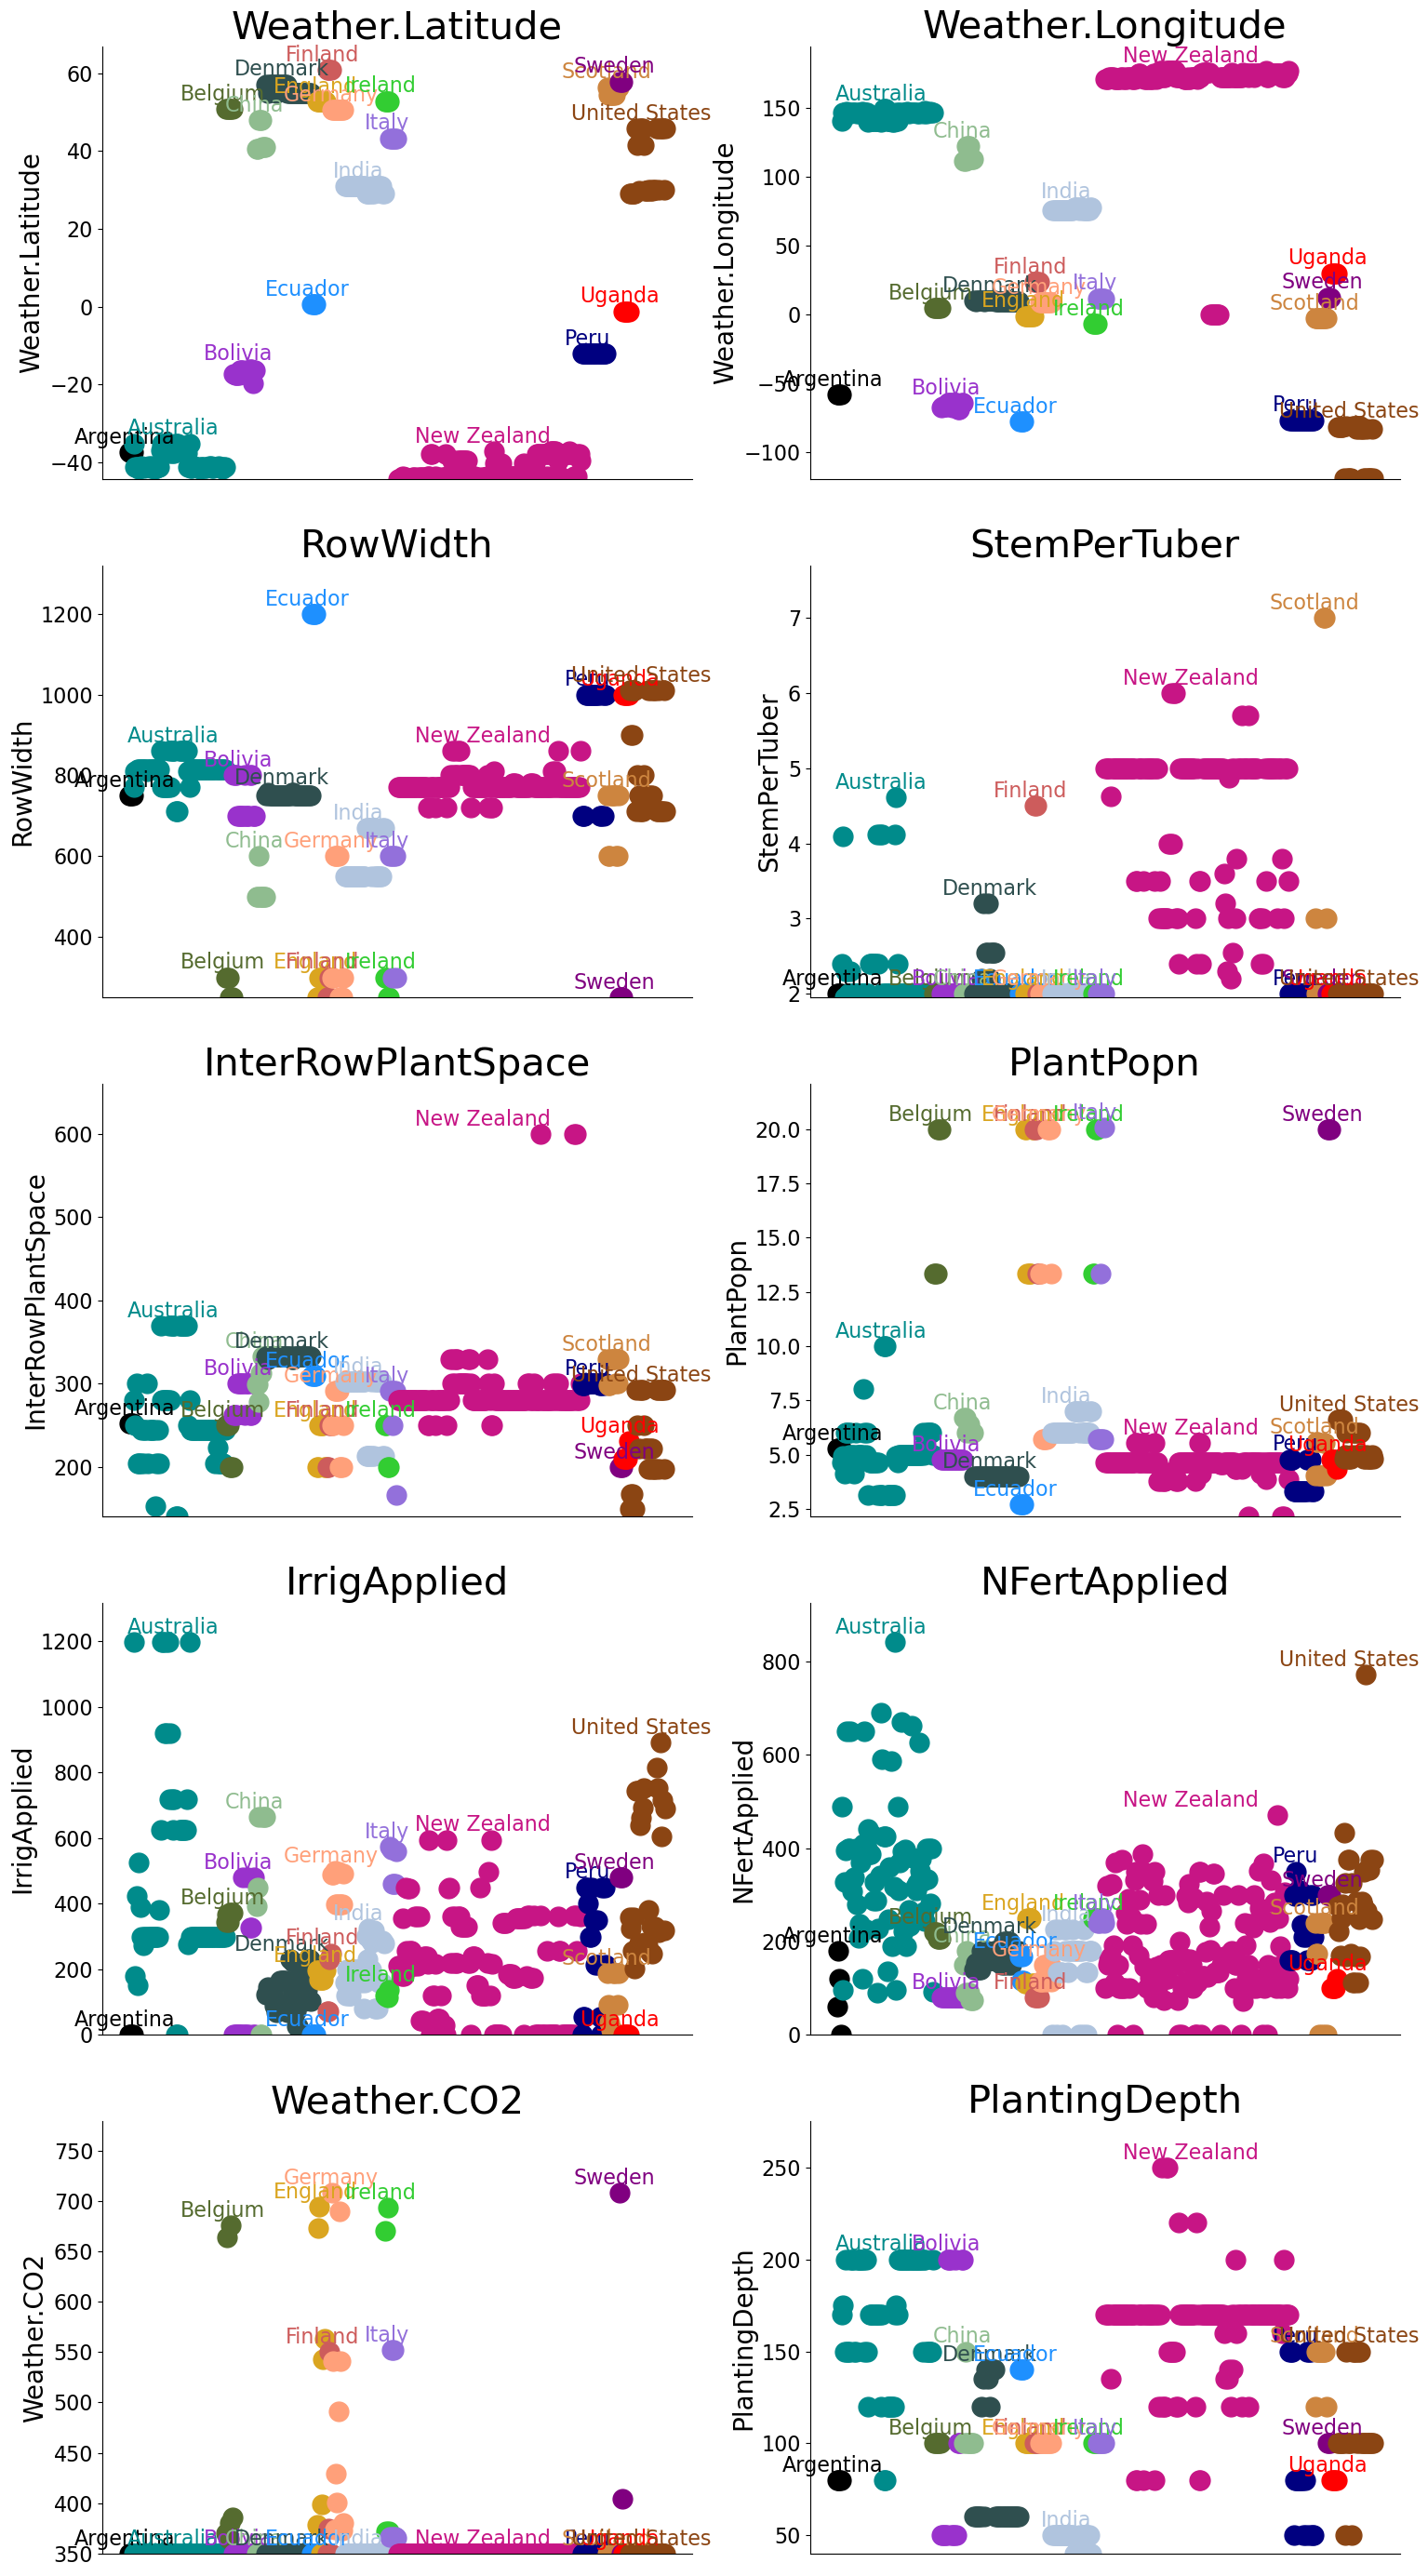

In [31]:
Graph = plt.figure(figsize=(18,35))
Vars = ['Weather.Latitude','Weather.Longitude',
       'RowWidth','StemPerTuber',
       'InterRowPlantSpace','PlantPopn',
       'IrrigApplied','NFertApplied',
       'Weather.CO2', 'PlantingDepth']
makeConfigPlots(Vars,'Country',Countries)

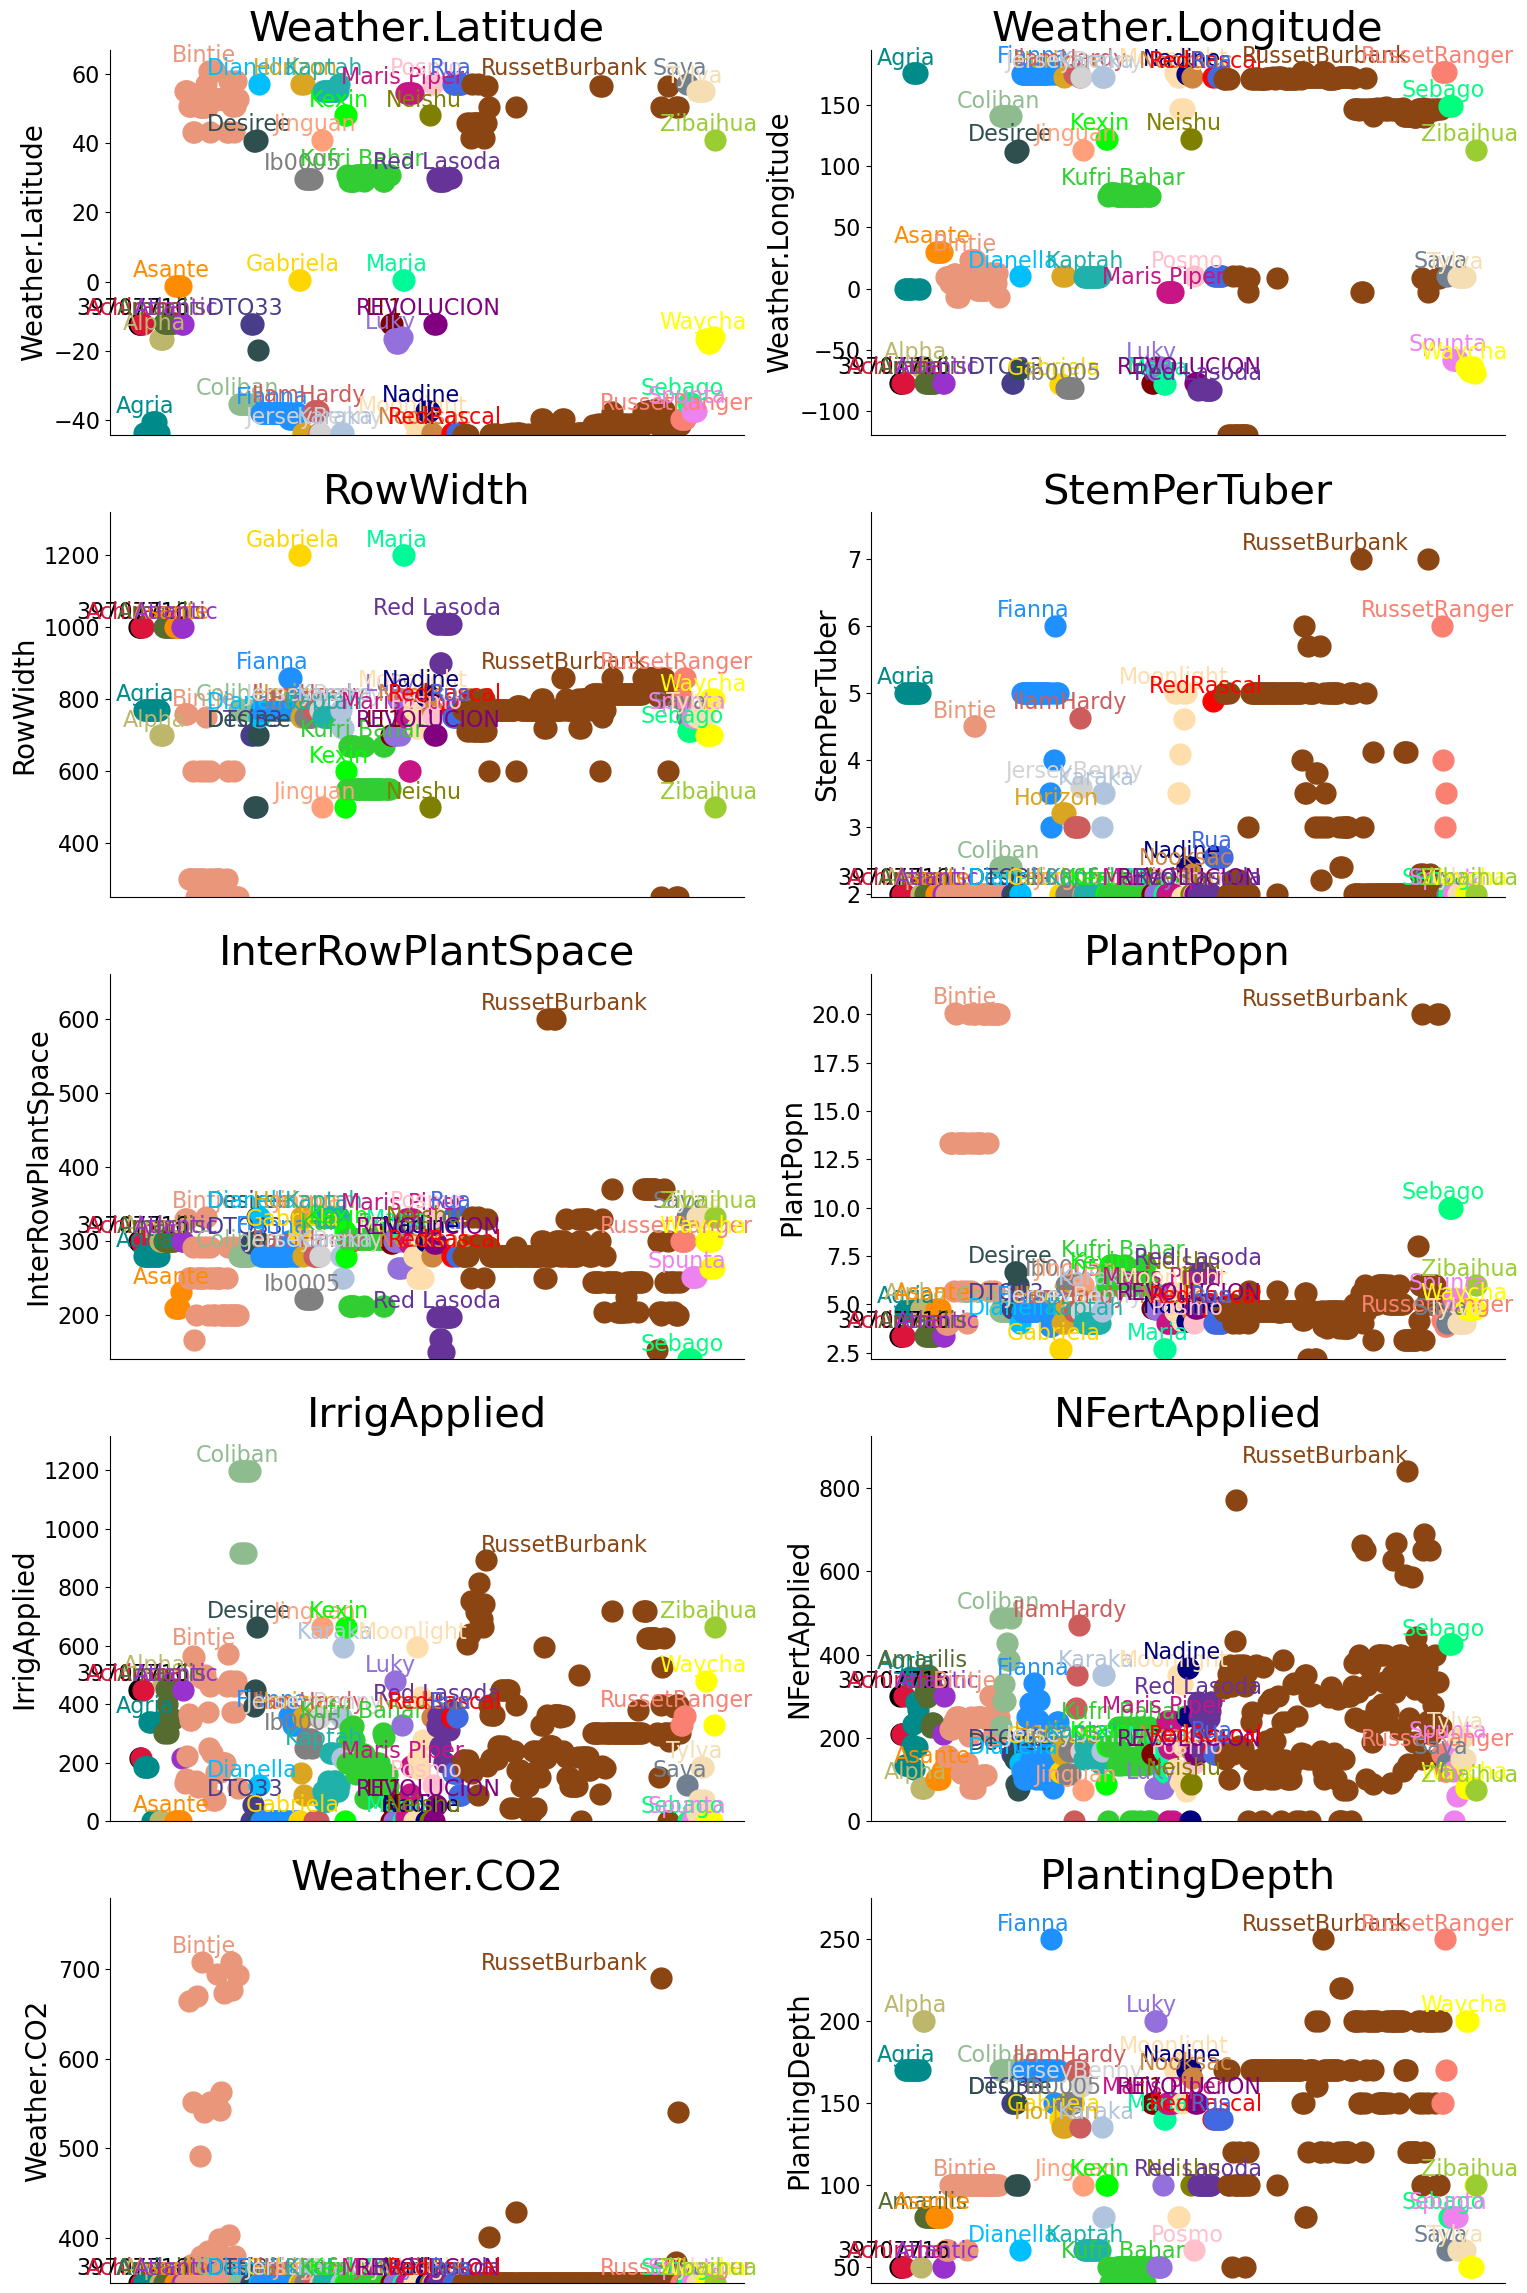

In [32]:
Graph = plt.figure(figsize=(18,35))
Vars = ['Weather.Latitude','Weather.Longitude',
       'RowWidth','StemPerTuber',
       'InterRowPlantSpace','PlantPopn',
       'IrrigApplied','NFertApplied',
       'Weather.CO2', 'PlantingDepth']
makeConfigPlots(Vars,'Cultivar',Cultivars)

In [33]:
def plotDepthVars(VarName,depthNorm):
    Thicks = InitialReport.loc[:,[X for X in InitialReport.columns if 'Thickness' in X]]
    Depths = Thicks.cumsum(axis=1)
    Vars = InitialReport.loc[:,[X for X in InitialReport.columns if VarName in X]]
    LayerDB = pd.DataFrame()
    for x in Depths.index:
        SimLayerDB = pd.DataFrame(index = pd.MultiIndex.from_product([[x],['LayerBounds','Varval']]))
        LayerBounds = [0.0]
        depthNormFact = 1 
        if depthNorm == True:
            depthNormFact = Thicks.loc[x,:][0]
        Varvals = [Vars.loc[x,:][0]/depthNormFact]
        for l in range(13):
            try:
                if depthNorm == True:
                    depthNormFact = Thicks.loc[x,:][l]
                LayerBounds.append(float(Depths.loc[x,:][l])*-1)
                Varvals.append(Vars.loc[x,:][l]/depthNormFact)
            except:
                do = 'Nothing'
        for p in range(len(LayerBounds)):
            SimLayerDB.loc[(x,'LayerBounds'),p] = LayerBounds[p]
            SimLayerDB.loc[(x,'Varval'),p] = Varvals[p]
        LayerDB = pd.concat([LayerDB,SimLayerDB])
        LayerDB.index = LayerDB.index.swaplevel()
        LayerBounds = LayerDB.stack().loc['LayerBounds']
        VarVals = LayerDB.stack().loc['Varval']
        LayerDB = pd.concat([LayerDB,SimLayerDB])
    MaxDep = LayerDB.loc[(slice(None),'LayerBounds'),:].min(axis=1).min()
    MinVar = LayerDB.loc[(slice(None),'Varval'),:].min(axis=1).min()
    MaxVar = LayerDB.loc[(slice(None),'Varval'),:].max(axis=1).max()    
    Graph = plt.figure(figsize=(10,20))
    cols = int(len(Locations)/5)+1
    pos=1
    for lcn in Locations:
        ax = Graph.add_subplot(cols,5,pos)
        #for x in Depths.index:
        #    plcn = InitialReport.loc[x,'Location']
        plt.plot(VarVals,LayerBounds,'o',color = 'lightgrey')
        plt.text(0.03,1.0,lcn,transform=ax.transAxes,fontsize=12)
        LocalVars = HarvestReport.loc[HarvestReport.loc[:,'Loc']==lcn,:].index
        for l in LocalVars:
            plt.plot(LayerDB.loc[(l,'Varval'),:],LayerDB.loc[(l,'LayerBounds'),:],'-o',color = 'red')
        plt.ylim(MaxDep*1.05,0)
        plt.xlim(MinVar * 0.8,MaxVar * 1.05)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if pos in range(1,200,5):
            plt.tick_params(axis='y', which='both', left=True,right=False, labelleft=True,labelsize=10)
            plt.ylabel('Depth (cm)',fontsize=12)
        else:
            plt.tick_params(axis='y', which='both', left=False,right=False, labelleft=False,labelsize=10)
        if pos in list(range(len(Locations)-4,len(Locations)+1)):
            plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=10)
            plt.xlabel(VarName,fontsize=12)
        else:
            plt.tick_params(axis='x', which='both', bottom=False,top=False, labelbottom=False,labelsize=10)
        pos += 1
    plt.tight_layout

## The flowing series of graphs show CropSoil configuration settings for each simulation so they can be sense checked against the rest of the validation set

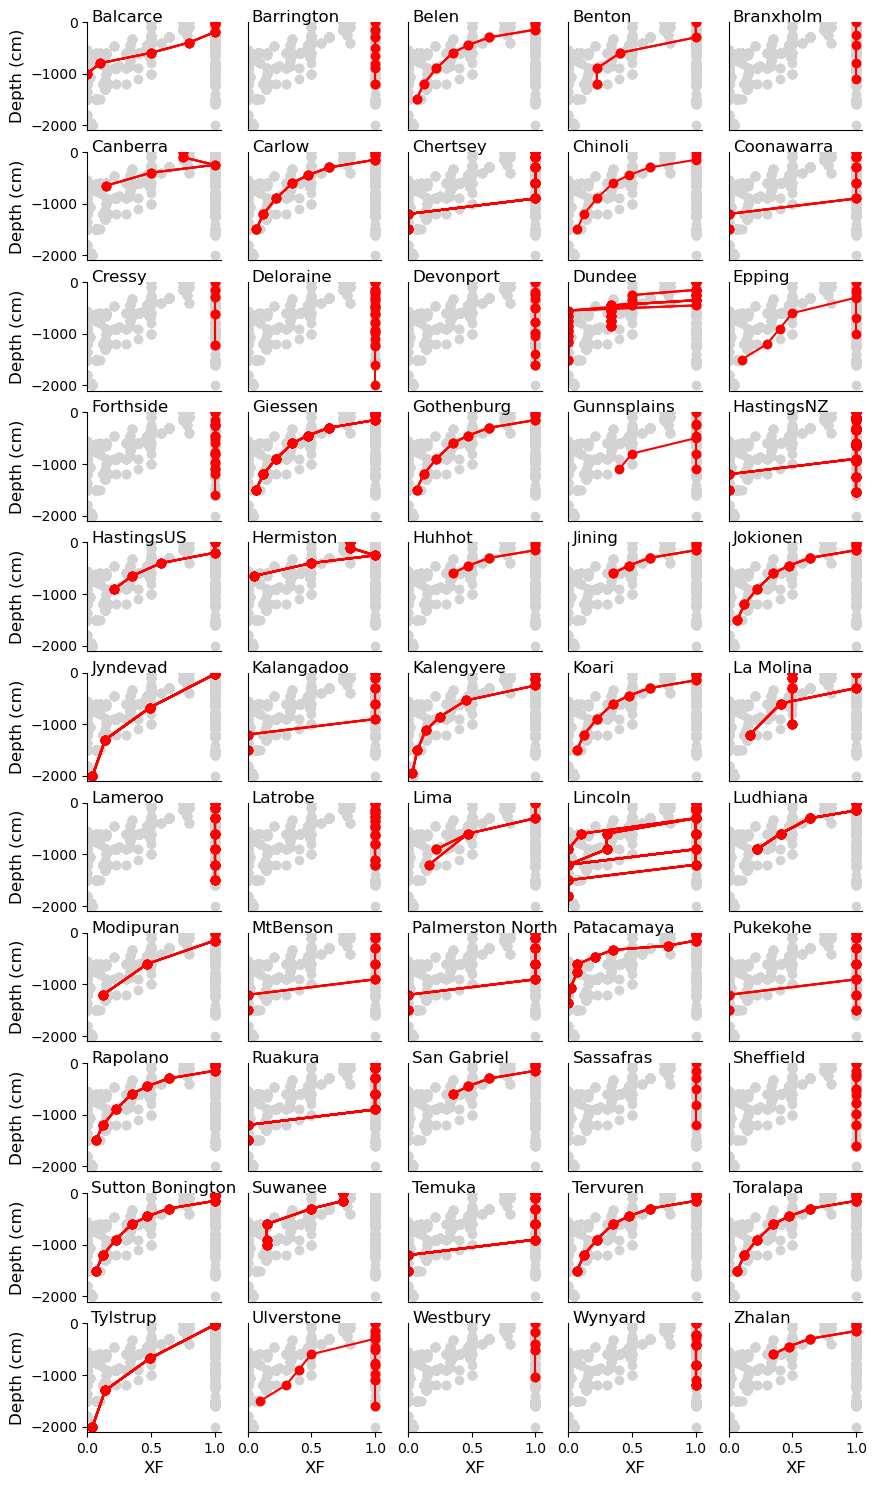

In [34]:
plotDepthVars('XF',False)

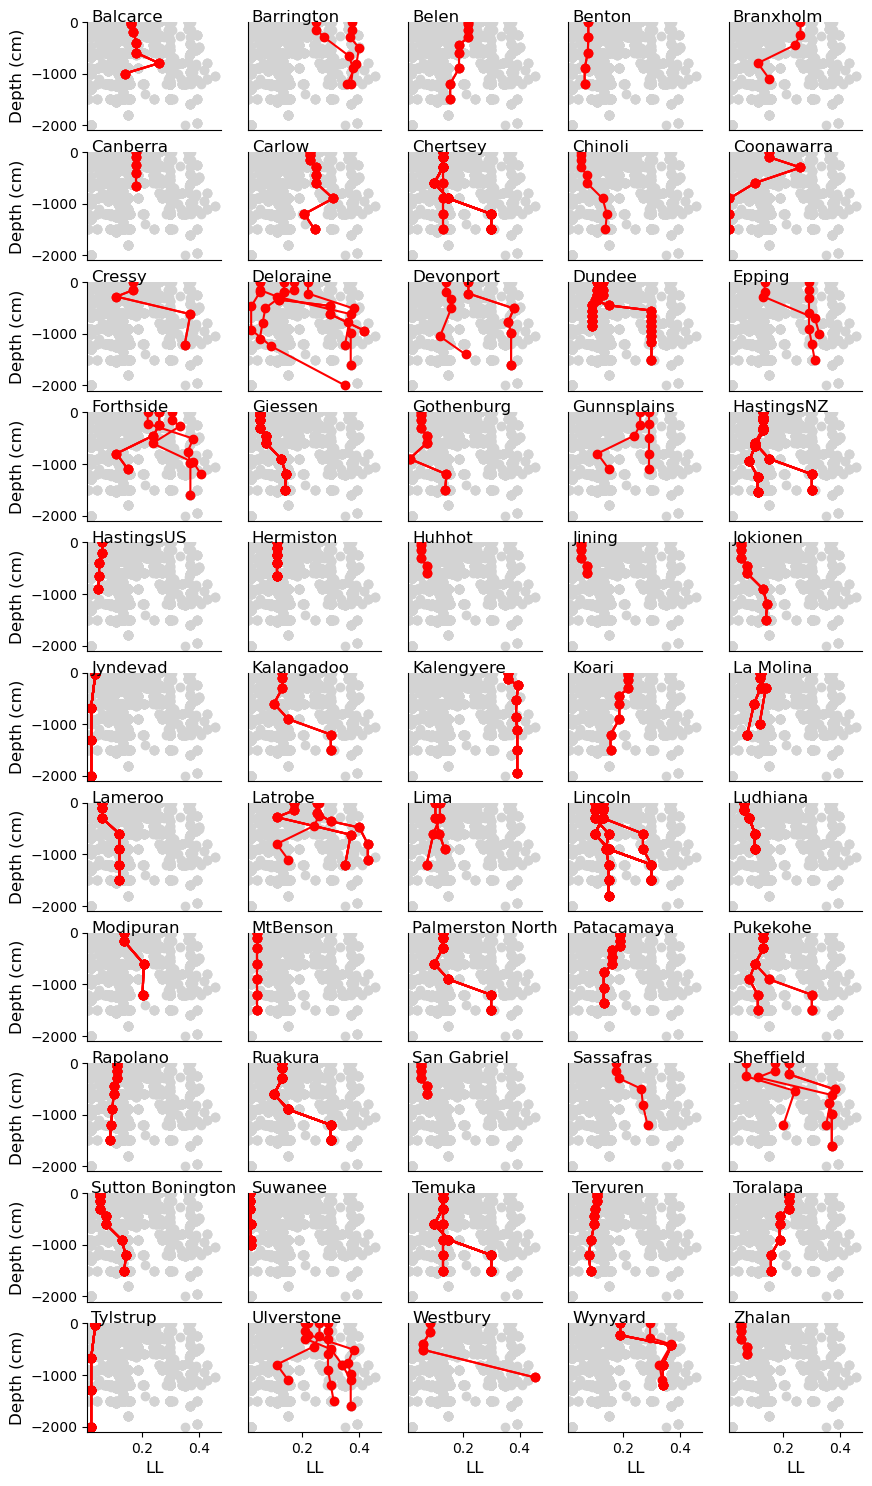

In [35]:
plotDepthVars('LL',False)

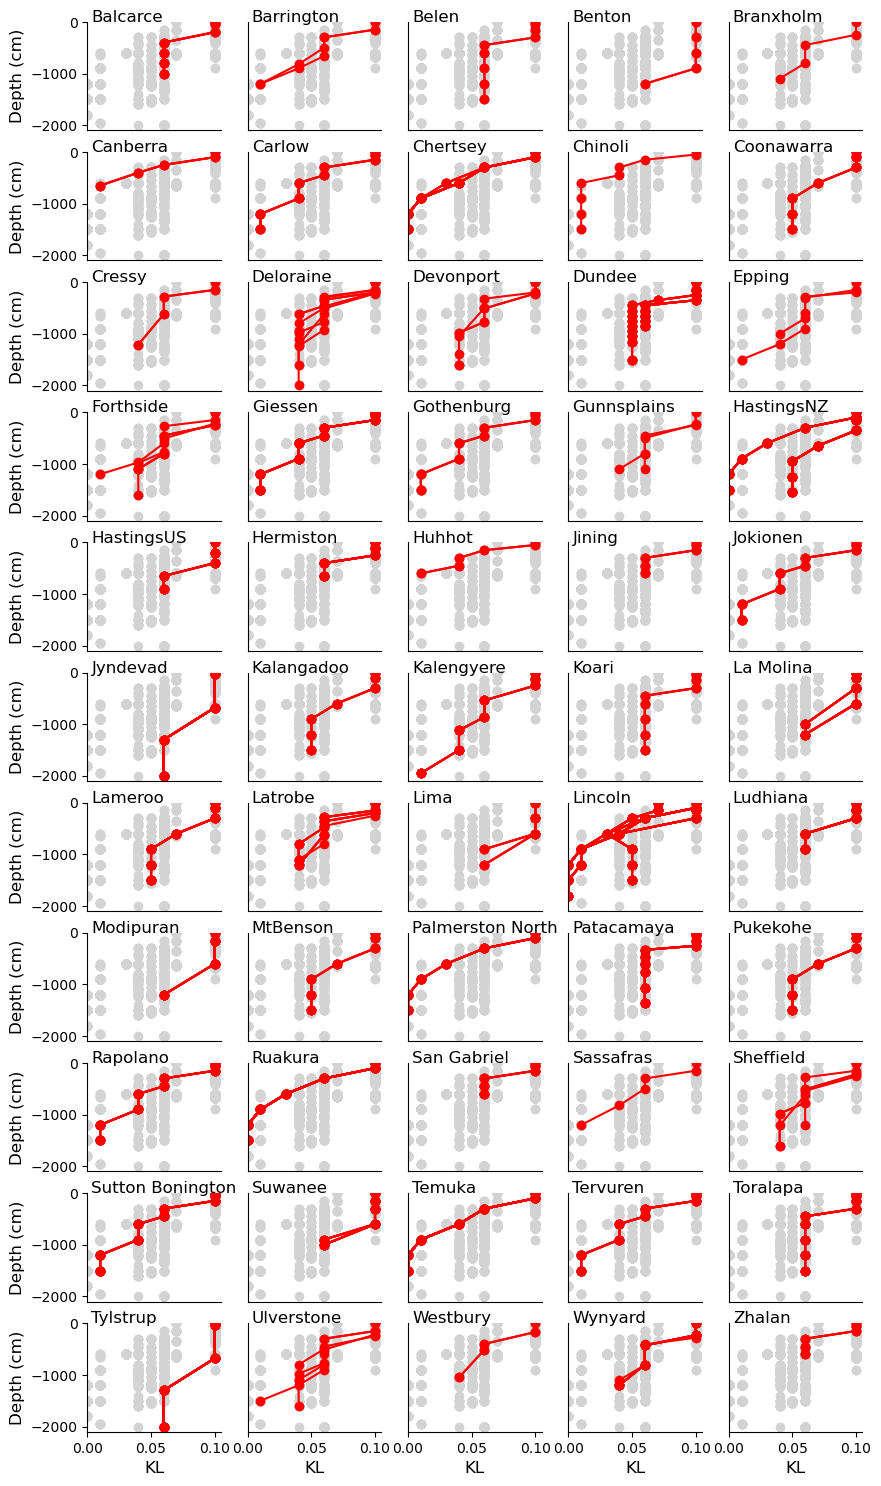

In [36]:
plotDepthVars('KL',False)

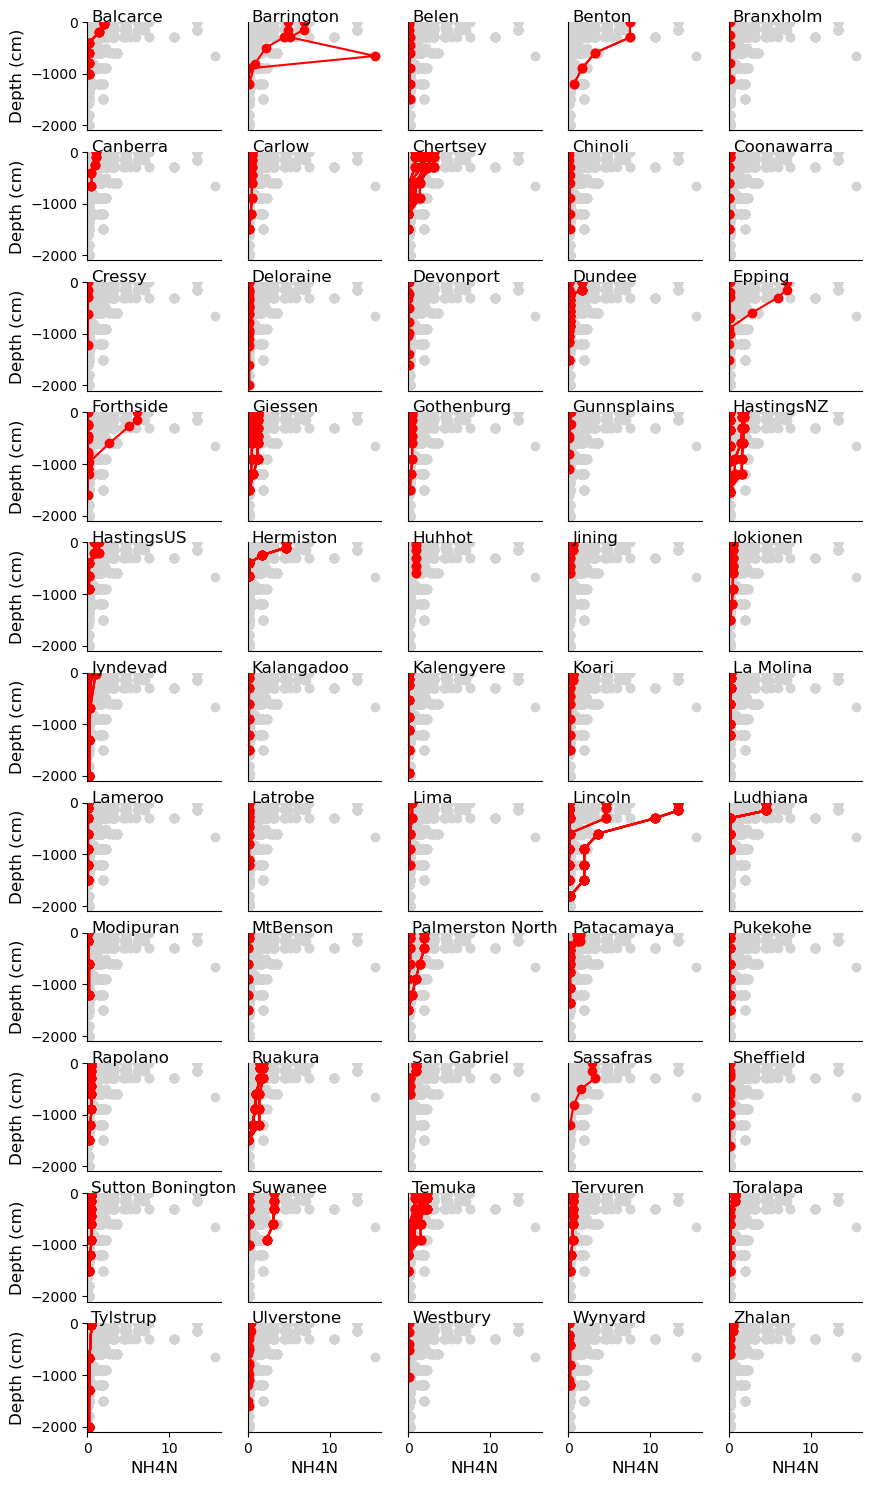

In [37]:
plotDepthVars('NH4N',False)

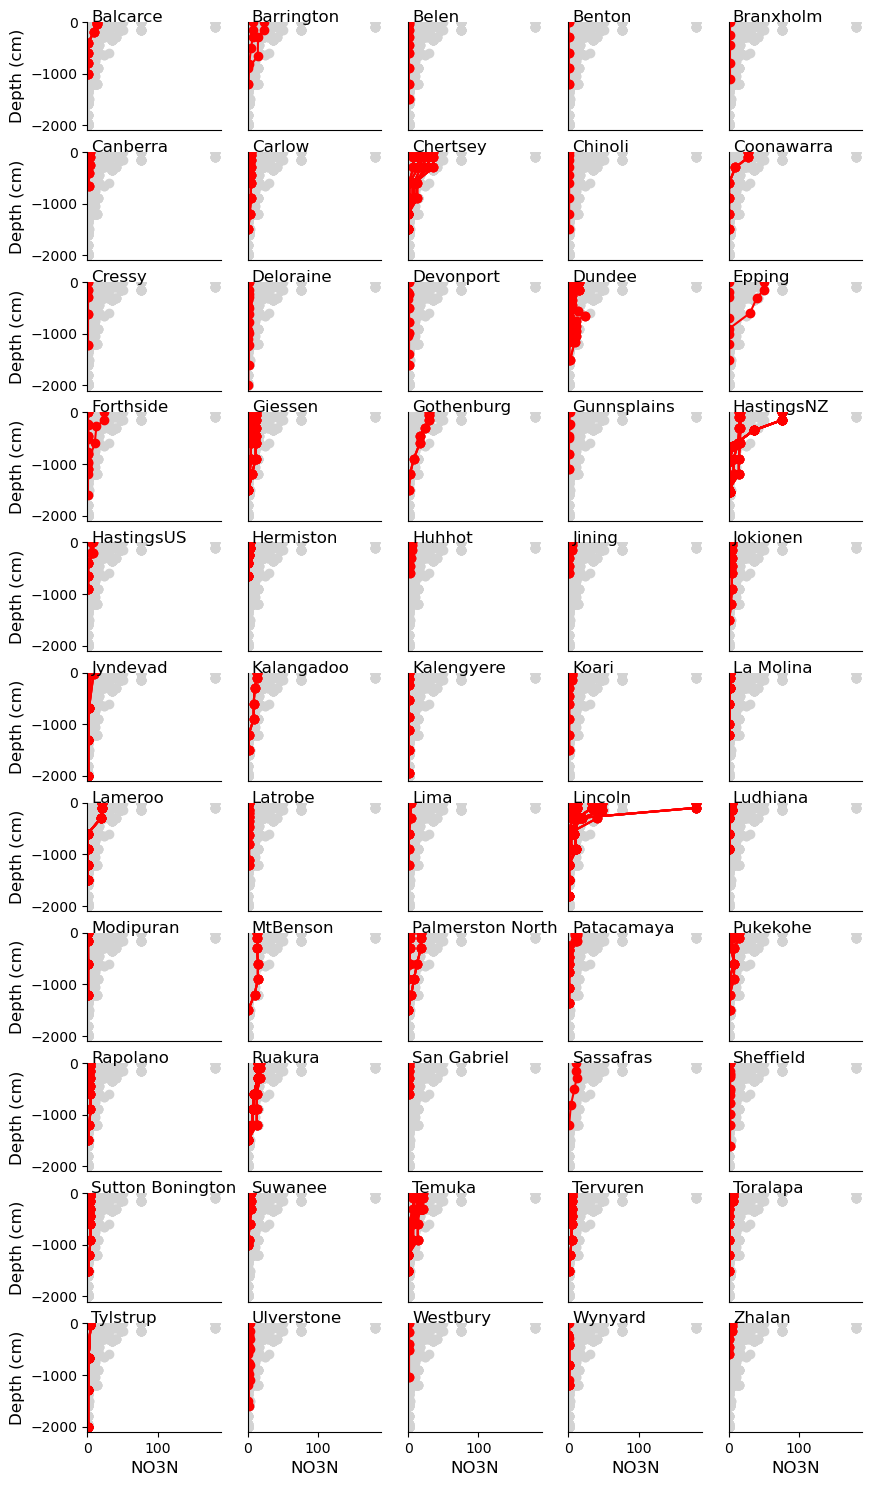

In [38]:
plotDepthVars('NO3N',False)

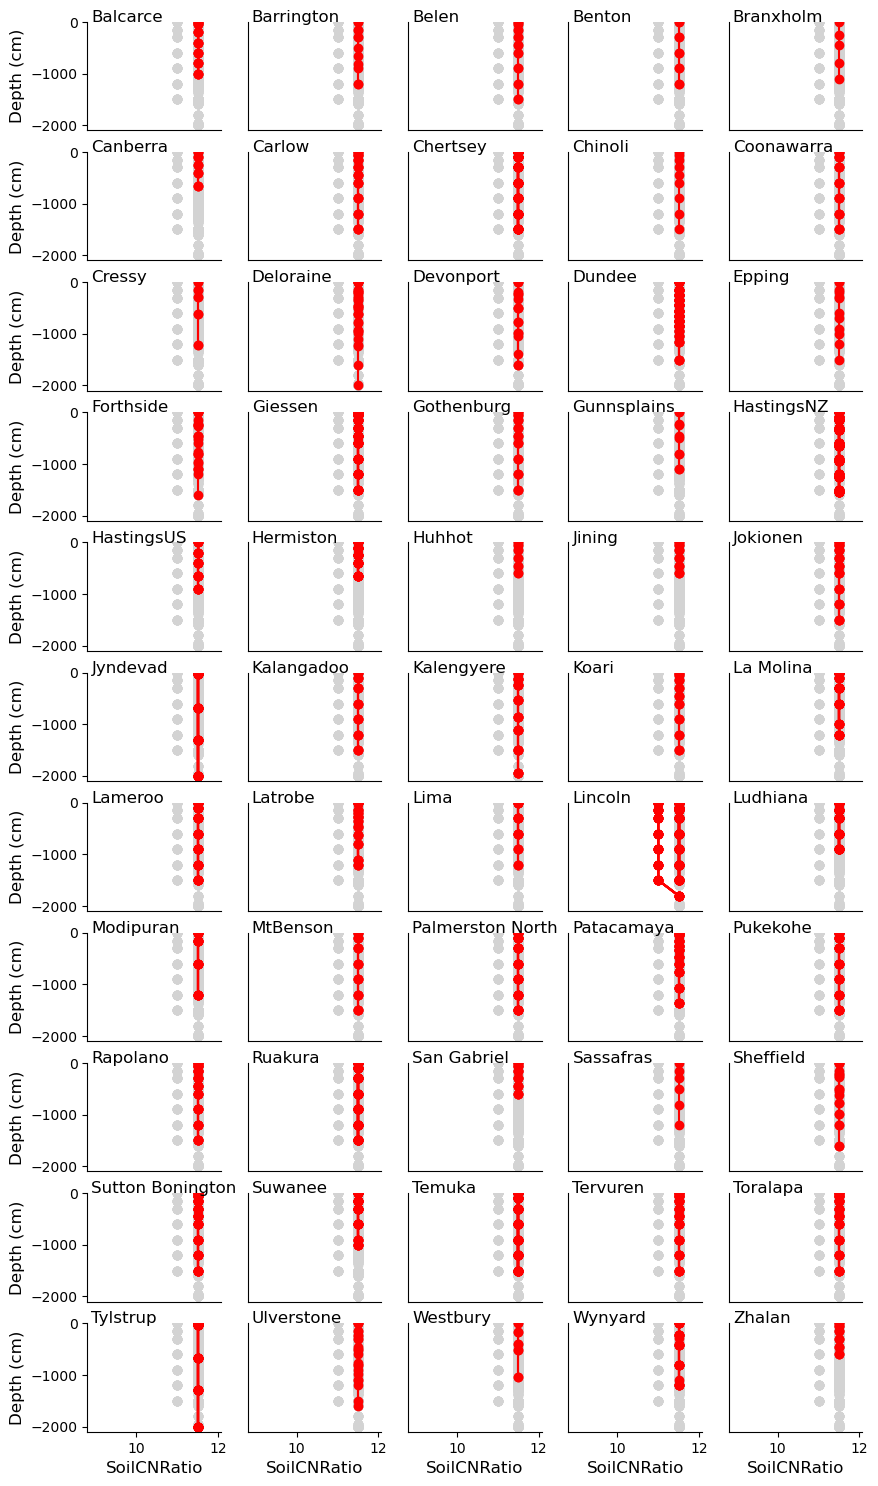

In [39]:
plotDepthVars('SoilCNRatio',False)

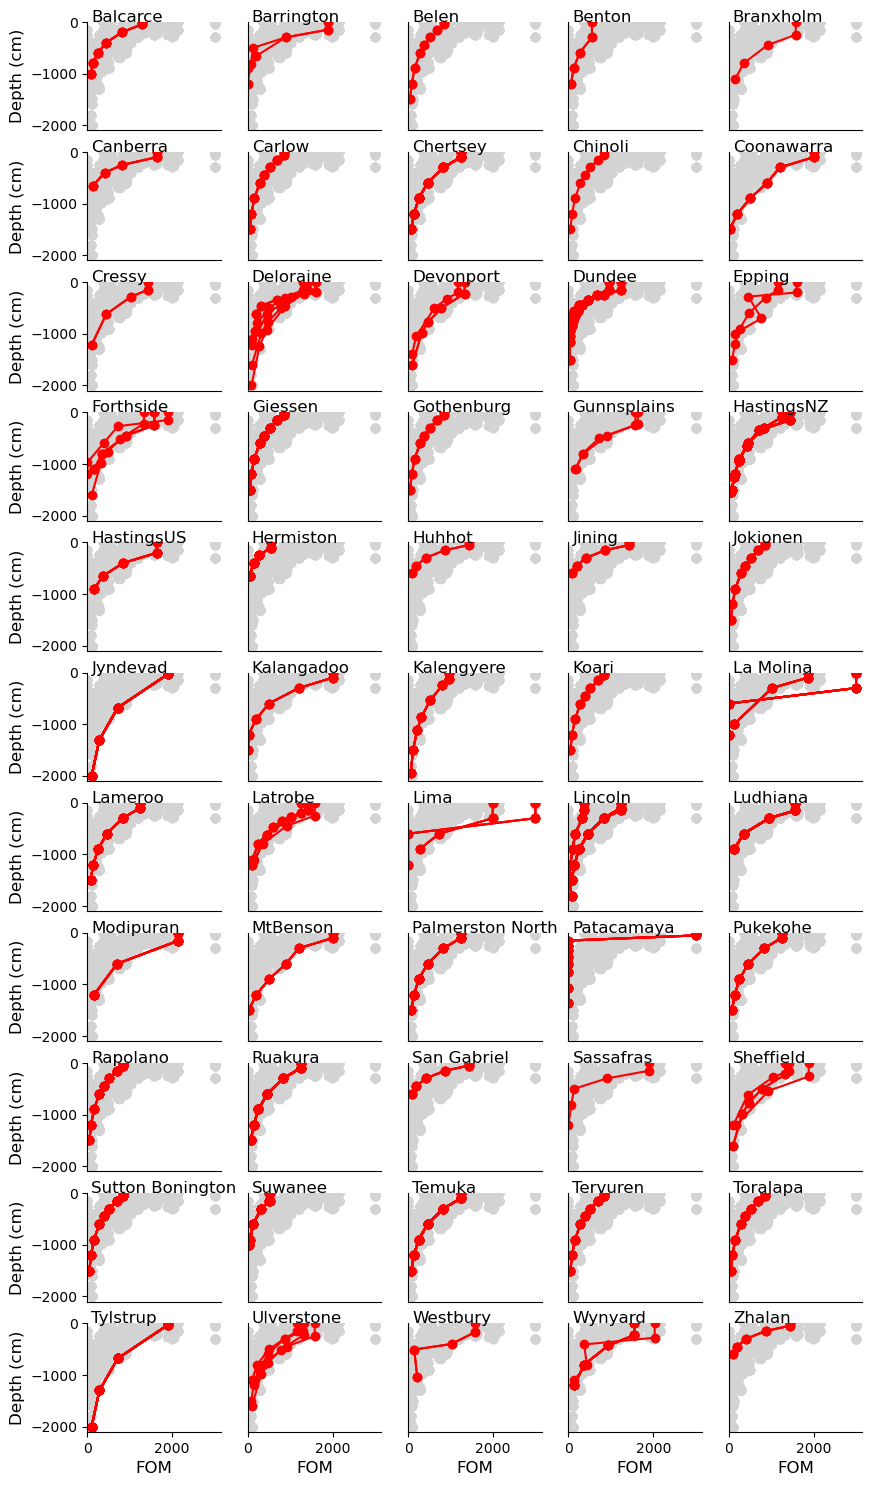

In [40]:
plotDepthVars('FOM',False)

In [41]:
def MakeLabel(RegStats):
    #text = RegStats.Name + '  n = ' + str(RegStats.n)
    text = '\ny = ' + '%.2f'%RegStats.Intercept + '(se ' + '%.2f'%RegStats.SEintercept + ') + ' + '%.2f'%RegStats.Slope + '(se ' + '%.2f'%RegStats.SEslope + ') x' 
    text += '\n$r^2$ =' + '%.2f'%RegStats.R2 + ' RMSE = ' + '%.2f'%RegStats.RMSE +' NSE = ' + '%.2f'%RegStats.NSE
    text += '\nME = ' + '%.2f'%RegStats.ME + ' MAE = ' + '%.2f'%RegStats.MAE
    text += '\nn = ' + str(RegStats.n)
    return text

def AddObsPredGraph(Variables,DataTable,GroupVar,GroupList):
    Pos = 1
    for Var in Variables:
        NaNFilter = np.isnan(DataTable.loc[:,'Predicted.'+Var]) | np.isnan(DataTable.loc[:,'Observed.'+Var])
        IaNFilter = ~NaNFilter
        Obs = DataTable.loc[:,'Observed.'+Var].loc[IaNFilter].values
        Pred = DataTable.loc[:,'Predicted.'+Var].loc[IaNFilter].values
        no = len(Variables)
        rows = int(no/3)+1
        ax = Graph.add_subplot(rows,3,Pos)
        ColPos = 0
        MarPos = 0
        for g in GroupList:
            ColDF = globals()[GroupVar+'Props']
            col = ColDF.loc[g,'Color']
            SimIDs = set(HarvestReport.loc[HarvestReport.loc[:,GroupVar] == g].index.values)
            ExpObs = DataTable.reindex(SimIDs).loc[:,'Observed.'+Var]
            ExpPred = DataTable.reindex(SimIDs).loc[:,'Predicted.'+Var]
            plt.plot(ExpObs,ExpPred,'o',color = col,label=g)
            ColPos +=1
            if ColPos == 30:
                ColPos = 1
                MarPos +=1
        uplim = max(Obs.max(),Pred.max())*1.1
        lowlim = min(Obs.min(),Pred.min())*0.95
        plt.text(0.02,0.94,VariablePars.loc[Var,'Names'],transform=ax.transAxes,fontsize=20)
        plt.ylim(0,uplim)
        plt.xlim(0,uplim)
        plt.plot([lowlim,uplim*.95],[lowlim,uplim*.95],'-',color='k')
        RegStats = MUte.MathUtilities.CalcRegressionStats(Var,Pred,Obs)
        LabelText = MakeLabel(RegStats)
        #plt.text(uplim*0.05,uplim*.78,LabelText)
        #Fit linear regression to current series and store slope and intercept in dataframe
        ModFit = sm.regression.linear_model.OLS(Pred,  # Y variable
                                            sm.add_constant(Obs), # X variable
                                            missing='drop',                                     # ignor and data where one value is missing
                                            hasconst=False) 
        RegFit = ModFit.fit();  # fit models parameters
        Slope = RegFit.params[1] 
        Intercept = RegFit.params[0]
        Xs = [lowlim,uplim*.95]
        Ys = [Intercept + Xs[0]*Slope,Intercept + Xs[1]*Slope]
        plt.plot(Xs,Ys,'--',color='r')
        plt.ylabel('Pred ' + VariablePars.loc[Var,'Names'] + ' ('  + VariablePars.loc[Var,'Units'] + ')')
        plt.xlabel('Obs ' + VariablePars.loc[Var,'Names'] + ' ('  + VariablePars.loc[Var,'Units'] + ')')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True)
        plt.tick_params(axis='y', which='both', left=True,right=False, labelbottom=True)
        if Pos == 1:
            GH.AddLegend(LegLoc = (0,1.1),labelsize=16,Title='',NCol=5,MScale=2)
        Pos +=1

## Standard Obs vs Pred graph for Harvest

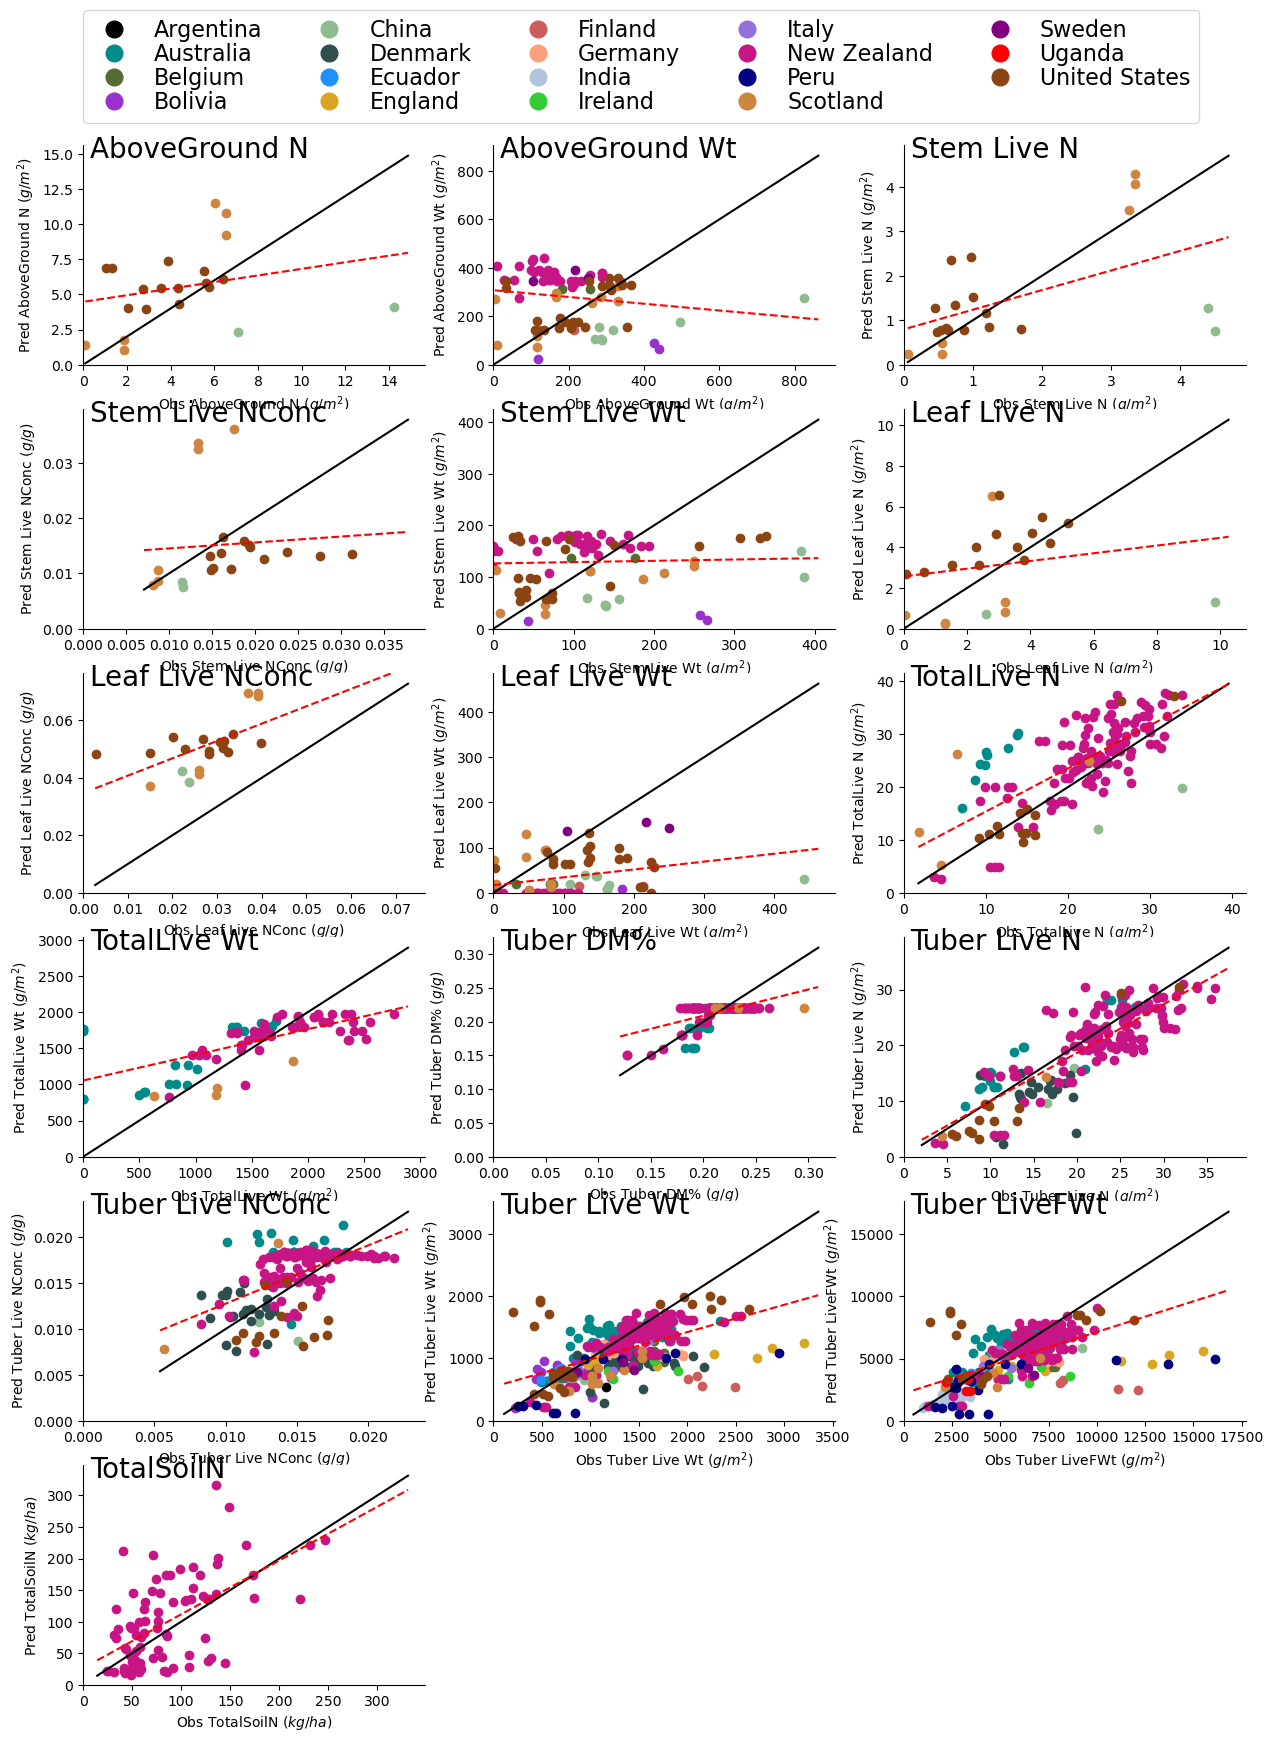

In [42]:
Graph = plt.figure(figsize=(15,20))
AddObsPredGraph(PlotVariables,HarvestPreObs,'Country',Countries)

## Standard Obs vs Pre graph for time series data

C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_13052\196230470.py:25: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  ExpObs = DataTable.reindex(SimIDs).loc[:,'Observed.'+Var]


ValueError: cannot reindex on an axis with duplicate labels

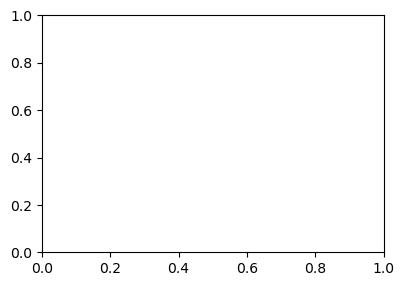

In [43]:
Graph = plt.figure(figsize=(15,40))
AddObsPredGraph(PlotDailyVariables,DailyPreObs,'Country',Countries)

In [ ]:
HarvestResiduals = HarvestPreObs.loc[:,[X for X in HarvestPreObs.columns if 'Pred-Obs' in X]].copy()

In [ ]:
def GroupResidulesGraph(Variables,ResidulesTable,GroupList,GroupVar):
    panpos = 1
    rows = len(Variables)
    for Var in Variables:
        ax = Graph.add_subplot(rows,1,panpos)
        startx = 0
        tickPoss = []
        tickLabs = []
        colpos = 1
        upper = ResidulesTable.loc[:,'Pred-Obs.' + Var].max() * 1.1
        lower = ResidulesTable.loc[:,'Pred-Obs.' + Var].min() * 1.1
        MeanResidual = ResidulesTable.loc[:,'Pred-Obs.' + Var].mean()
        TextPos = 'Lower'
        for group in GroupList:
            ColDF = globals()[GroupVar+'Props']
            col = ColDF.loc[group,'Color']
            SimIDs = HarvestReport.loc[HarvestReport.loc[:,GroupVar]==group,:].index.values
            xvals = range(startx,startx+len(SimIDs))
            plt.plot(xvals,ResidulesTable.reindex(SimIDs,axis=0).loc[:,'Pred-Obs.' + Var],
                     '-o',color=col)
            #tickPoss.append(startx+len(SimIDs)/2)
            tickLabs.append(group)
            if TextPos=='Lower':
                plt.text(startx+len(SimIDs)/2,lower,group,fontsize=16,
                         color=col,rotation=-45,verticalalignment='bottom',horizontalalignment='center')
                TextPos = 'Upper'
            else:
                plt.text(startx+len(SimIDs)/2,upper,group,fontsize=16,
                         color=col,rotation=-45,verticalalignment='top',horizontalalignment='center')
                TextPos = 'Lower'
            startx += len(SimIDs)
            if colpos == 30:
                colpos = 0
            colpos+=1
        ax.xaxis.set_major_locator(plt.FixedLocator(tickPoss))
        ax.set_xticklabels(tickLabs)
        plt.tick_params(rotation=90)
        plt.plot([0,startx],[MeanResidual,MeanResidual],'-',lw=3,color='k')
        plt.plot([0,startx],[0,0],'--',lw=3,color='k')
        plt.ylim(lower,upper)
        plt.title(Var,fontsize=25)
        plt.ylabel('Pred-Obs')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True)
        plt.tick_params(axis='y', which='both', left=True,right=False, labelbottom=True)
        panpos+=1

## Graph residuals for key variables grouped by cultivar

In [ ]:
Graph = plt.figure(figsize=(15,60))
GroupResidulesGraph(PlotVariables,HarvestResiduals,Cultivars,'Cultivar')

## Graph residuals for key variables grouped by location

In [ ]:
Graph = plt.figure(figsize=(15,60))
GroupResidulesGraph(PlotVariables,HarvestResiduals,Countries,'Country')

## Make graphs of residuals vs simulation configuration variables

In [ ]:
def ResidulesVsVariable(ResidulesTable,Variable,GroupList,GroupVar,XVariables):
    pos = 1
    for vsVariable in XVariables:
        ax = Graph.add_subplot(4,2,pos)
        for group in GroupList:
            ColDF = globals()[GroupVar+'Props']
            col = ColDF.loc[group,'Color']
            SimIDs = HarvestReport.loc[HarvestReport.loc[:,GroupVar]==group,:].index.values
            yvals = ResidulesTable.reindex(SimIDs,axis=0).loc[:,'Pred-Obs.Potato.'+Variable]
            xvals = HarvestReport.reindex(SimIDs,axis=0).loc[:,vsVariable]
            plt.plot(xvals,yvals,'o',color=col,label=group)
            upper = HarvestReport.loc[:,vsVariable].max() * 1.1
            lower = HarvestReport.loc[:,vsVariable].min() * 0.8
            MeanResidual = ResidulesTable.loc[:,'Pred-Obs.Potato.' + Variable].mean()
            plt.plot([lower,upper],[MeanResidual,MeanResidual],'-',lw=3,color='k')
            plt.plot([lower,upper],[0,0],'--',lw=3,color='k')
            plt.title('Pred-Obs ' + Variable + ' vs ' + vsVariable)
            plt.ylabel('Pred-Obs ' + Variable)
            plt.xlabel(vsVariable)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True)
        plt.tick_params(axis='y', which='both', left=True,right=False, labelbottom=True)
        if pos == 1:
            GH.AddLegend(LegLoc = (0,1.1),labelsize=16,Title='',NCol=5,MScale=2)
        pos+=1

In [ ]:
Graph = plt.figure(figsize=(15,20))
XVariables = ['IrrigApplied','NFertApplied','Weather.Latitude',
'Weather.Longitude','PlantPopn','StemPopn','Weather.CO2','PlantingDepth']
ResidulesVsVariable(HarvestResiduals,'Tuber.Live.Wt',Cultivars,'Cultivar',XVariables)

In [ ]:
Graph = plt.figure(figsize=(15,20))
XVariables = ['IrrigApplied','NFertApplied','Weather.Latitude',
'Weather.Longitude','PlantPopn','StemPopn','Weather.CO2','PlantingDepth']
ResidulesVsVariable(HarvestResiduals,'Tuber.Live.Wt',Countries,'Country',XVariables)

In [ ]:
def simsWithTimeCoarseData(Var):
    SimsWithTimeCoarseData = []
    for sim in DailyPreObs.index.drop_duplicates():
        try:
            obsNo = len(DailyPreObs.loc[sim,'Pred-Obs.Potato.'+Var].dropna().values)
            if obsNo>1:
                SimsWithTimeCoarseData.append(sim)
        except:
            do = 'Nothing'
    return SimsWithTimeCoarseData

def ResidulesVsTtSow(Variable,GroupLabel,colourLabel):
    SimsWithTimeDataForVar = simsWithTimeCoarseData(Variable)
    WithTimeCoarseData = HarvestReport.reindex(SimsWithTimeDataForVar,axis=0).loc[:,GroupLabel].dropna().drop_duplicates().values
    Grouping = WithTimeCoarseData
    Grouping.sort()
    cols = np.ceil(len(Grouping)/5)
    pos=1
    upper = DailyPreObs.loc[:,'Pred-Obs.Potato.'+Variable].max() * 1.1
    lower = DailyPreObs.loc[:,'Pred-Obs.Potato.'+Variable].min() * 0.8
    MeanResidual = DailyPreObs.loc[:,'Pred-Obs.Potato.'+Variable].mean()
    DailyObsPredSims = DailyPreObs.index.drop_duplicates()
    for group in Grouping:
        ax = Graph.add_subplot(cols,5,pos)
        simsInGroup = HarvestReport.loc[HarvestReport.loc[:,GroupLabel]==group].index
        GroupSimsWithTimeCoarseData = list(set(HarvestReport.loc[HarvestReport.loc[:,GroupLabel]==group].index) & set(SimsWithTimeDataForVar))
        for sim in GroupSimsWithTimeCoarseData:
            col = ColProps.loc[sim,colourLabel]
            residuals = DailyPreObs.loc[sim,'Pred-Obs.Potato.'+Variable]
            DatesWithObs = DailyReport.loc[:,'Clock.Today'].isin(DailyPreObs.loc[sim,'Clock.Today'])
            TtSow = DailyReport.loc[DatesWithObs,:].loc[sim,'Potato.Phenology.AccumulatedEmergedTT'].values
            try:
                plt.plot(TtSow,residuals,'o-',color=col,label=group)
            except:
                print(DailyReport.loc[sim,'SimulationName'].drop_duplicates())
        plt.text(0.03,1.0,group,transform=ax.transAxes,fontsize=12)
        plt.ylim(lower,upper)
        plt.plot([0,2300],[MeanResidual,MeanResidual],'-',lw=3,color='k')
        plt.plot([0,2300],[0,0],'--',lw=3,color='k')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if pos in range(1,200,5):
            plt.tick_params(axis='y', which='both', left=True,right=False, labelleft=True,labelsize=10)
            plt.ylabel('Pred-Obs '+Variable,fontsize=12)
        else:
            plt.tick_params(axis='y', which='both', left=False,right=False, labelleft=False,labelsize=10)
        if pos in list(range(len(Grouping)-4,len(Grouping)+1)):
            plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=10)
            plt.xlabel('TtAccumSow',fontsize=12)
        else:
            plt.tick_params(axis='x', which='both', bottom=False,top=False, labelbottom=False,labelsize=10)
        pos+=1
    plt.tight_layout

## Make Graphs of tuber live Wt residuals for each location plotted against thermal time since sowing

In [ ]:
Graph = plt.figure(figsize=(15,10))
PlotVar = 'Tuber.Live.Wt'
SortVar = 'Country'
ColorVar = 'Cultivar'
ResidulesVsTtSow(PlotVar,SortVar,ColorVar)

## Make Graphs of tuber live Wt residuals for each Cultivar plotted against thermal time since sowing

In [ ]:
Graph = plt.figure(figsize=(15,20))
PlotVar = 'Tuber.Live.Wt'
SortVar = 'Cultivar'
ColorVar = 'Country'
ResidulesVsTtSow(PlotVar,SortVar,ColorVar)

## Make Graphs of LAI residuals for each cultivar plotted against thermal time since sowing

In [ ]:
Graph = plt.figure(figsize=(15,10))
PlotVar = 'Leaf.LAI'
SortVar = 'Cultivar'
ColorVar = 'Country'
ResidulesVsTtSow(PlotVar,SortVar,ColorVar)

In [ ]:
Graph = plt.figure(figsize=(15,10))
PlotVar = 'Leaf.Live.NConc'
SortVar = 'Cultivar'
ColorVar = 'Country'
ResidulesVsTtSow(PlotVar,SortVar,ColorVar)

In [ ]:
Graph = plt.figure(figsize=(15,20))
PlotVar = 'Leaf.Live.Wt'
SortVar = 'Cultivar'
ColorVar = 'Country'
ResidulesVsTtSow(PlotVar,SortVar,ColorVar)

In [ ]:
Graph = plt.figure(figsize=(15,20))
PlotVar = 'Stem.Live.Wt'
SortVar = 'Cultivar'
ColorVar = 'Country'
ResidulesVsTtSow(PlotVar,SortVar,ColorVar)

In [ ]:
Graph = plt.figure(figsize=(15,20))
PlotVar = 'Stem.Live.Wt'
SortVar = 'Cultivar'
ColorVar = 'Country'
ResidulesVsTtSow(PlotVar,SortVar,ColorVar)

In [ ]:
Graph = plt.figure(figsize=(15,10))
ResidulesVsTtSow('Leaf.LAI','Cultivar','Country')

In [ ]:
CultByCountry = HarvestReport.reindex(['Country','Cultivar'],axis=1).drop_duplicates()
for CbC in CultByCountry.index:
    CultCountryFilter = (HarvestReport.loc[:,'Country'] == CultByCountry.loc[CbC,'Country']) & \
                        (HarvestReport.loc[:,'Cultivar'] == CultByCountry.loc[CbC,'Cultivar'])
    CultByCountry.loc[CbC,'Count'] = HarvestReport.loc[CultCountryFilter,:].index.size

Graph = plt.figure(figsize=(12,10))
MaxSize = CultByCountry.loc[:,'Count'].max() * 1.5
for CbC in CultByCountry.index:
    col = ColProps.loc[CbC,'Cultivar']
    size = CultByCountry.loc[CbC,'Count']
    Alpha = (MaxSize-size)/MaxSize
    plt.plot(CultByCountry.loc[CbC,'Country'],CultByCountry.loc[CbC,'Cultivar'],'o',color=col,ms=size,alpha=Alpha)
plt.xticks(rotation=45)
CountryCounts = CultByCountry.groupby('Country').sum().sort_values('Count',ascending=False)
CultivarCounts = CultByCountry.groupby('Cultivar').sum().sort_values('Count',ascending=False)
for c in CountryCounts.index:
    plt.text(c,-1.5,int(CountryCounts.loc[c,'Count']),verticalalignment='bottom',horizontalalignment='center')
for c in CultivarCounts.index:
    plt.text(-1.5,c,int(CultivarCounts.loc[c,'Count']),verticalalignment='center',horizontalalignment='left')
plt.xlim(-2,20)

## Calculated long term mean temperature patterns from Tav, Amp and Lattitude

In [ ]:
#day of year of nthrn summer solstice
nth_solst = 173.0
#delay from solstice to warmest day (days)
temp_delay = 27.0
#warmest day of year in nth hemisphere
nth_hot = nth_solst + temp_delay
#day of year of sthrn summer solstice
sth_solst = nth_solst + 365.25 / 2.0
#warmest day of year of sth hemisphere
sth_hot = sth_solst + temp_delay
my_pi = 3.14159
ang = (2.0 * my_pi) / 365.25

def calcAlx(latitude,doy):
    date = datetime.datetime(2000,1,1) + datetime.timedelta(doy)
    if (latitude >= 0):
        alx = ang * (date - datetime.timedelta(nth_hot)).timetuple().tm_yday#_today.AddDays(-(int)nth_hot).DayOfYear;
    else:
        alx = ang * (date - datetime.timedelta(sth_hot)).timetuple().tm_yday#_today.AddDays(-(int)sth_hot).DayOfYear;
    if ((alx < 0.0) | (alx > 6.31)):
        print("Value for alx is out of range")
        raise 
    else:
        return alx
    
def estTemp(doy,latitude,Tav,Amp):
    alx = calcAlx(latitude,doy)
    return Tav + (Amp / 2.0) * np.cos(alx)

LongTermMeanTemp = pd.DataFrame(index=range(1,366),columns = Locations)

for l in LongTermMeanTemp.columns:
    for d in LongTermMeanTemp.index:
        params = InitialReport.loc[InitialReport.Loc == l,
                                   ['Weather.Latitude','Weather.Tav','Weather.Amp']].drop_duplicates()
        LongTermMeanTemp.loc[d,l] = estTemp(d,
                                            params.iloc[0,0],
                                            params.iloc[0,1],
                                            params.iloc[0,2])

In [ ]:
def WeatherVsDAS(Variable,GroupLabel,colourLabel):
    Grouping = HarvestReport.loc[:,GroupLabel].dropna().drop_duplicates().values
    cols = np.ceil(len(Grouping)/3)
    pos=1
    upper = DailyReport.loc[:,'Weather.'+Variable].max() * 1.1
    lower = DailyReport.loc[:,'Weather.'+Variable].min() * 0.8
    for group in Grouping:
        ax = Graph.add_subplot(cols,3,pos)
        simsInGroup = HarvestReport.loc[HarvestReport.loc[:,GroupLabel]==group].index
        GroupSims = HarvestReport.loc[HarvestReport.loc[:,GroupLabel]==group].index
        for sim in GroupSims:
            col = ColProps.loc[sim,colourLabel]
            DAS = DailyReport.loc[sim,'Clock.Today.DayOfYear']
            NonZeros = DAS>0
            DAS = DAS.loc[NonZeros]
            absolutes = DailyReport.loc[sim,'Weather.'+Variable].loc[NonZeros]
            try:
                plt.plot(DAS,absolutes,'o',color=col,label=group)
                if Variable == 'Radn':
                    qmax = DailyReport.loc[sim,'Weather.Qmax'].loc[NonZeros]
                    plt.plot(DAS,qmax,'o',color='gold',label='qmax')
                if Variable == 'MaxT':
                    MinT = DailyReport.loc[sim,'Weather.MinT'].loc[NonZeros]
                    plt.plot(DAS,MinT,'o',color=col,label=group,alpha=0.5,mfc='white')
                    plt.plot(LongTermMeanTemp.index,LongTermMeanTemp.loc[:,group],'-',color='gold')
                
            except:
                print(DailyReport.loc[sim,'SimulationName'].drop_duplicates())
        plt.text(0.03,1.0,group + ', ' + HarvestReport.loc[sim,'Country'] + \
                 ' (' +  str(HarvestReport.loc[sim,'Weather.Latitude']) + ' deg)',
                 transform=ax.transAxes,fontsize=12)
        plt.ylim(lower,upper)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.xlim(0,366)
        if pos in range(1,200,3):
            plt.tick_params(axis='y', which='both', left=True,right=False, labelleft=True,labelsize=10)
            plt.ylabel(Variable,fontsize=12)
        else:
            plt.tick_params(axis='y', which='both', left=False,right=False, labelleft=False,labelsize=10)
        if pos in list(range(len(Grouping)-2,len(Grouping)+1)):
            plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=10)
            plt.xlabel('DoY',fontsize=12)
        else:
            plt.tick_params(axis='x', which='both', bottom=False,top=False, labelbottom=False,labelsize=10)
        pos+=1
    plt.tight_layout

In [ ]:
Graph = plt.figure(figsize=(15,40))
WeatherVsDAS('Radn','Loc','Country')

In [ ]:
Graph = plt.figure(figsize=(15,40))
WeatherVsDAS('MaxT','Loc','Country')

In [ ]:
Graph = plt.figure(figsize=(15,40))
WeatherVsDAS('Wind','Loc','Country')

In [ ]:
Graph = plt.figure(figsize=(15,40))
WeatherVsDAS('VPD','Loc','Country')

In [ ]:
Graph = plt.figure(figsize=(15,40))
WeatherVsDAS('Rain','Loc','Country')

In [ ]:
DailyReport.loc[:,'RadResid'] = (DailyReport.loc[:,'Weather.Qmax'] - DailyReport.loc[:,'Weather.Radn'])/DailyReport.loc[:,'Weather.Qmax']
DailyReport.loc[:,'RadRel'] =  DailyReport.loc[:,'Weather.Radn']/DailyReport.loc[:,'Weather.Qmax'] 

In [ ]:
Graph = plt.figure(figsize=(15,40))
GroupLabel='Loc'
Grouping = HarvestReport.loc[:,GroupLabel].dropna().drop_duplicates().values
cols = np.ceil(len(Grouping)/3)
pos=1
upper = DailyReport.loc[:,'RadResid'].max() * 1.1
lower = DailyReport.loc[:,'RadResid'].min() * 0.8
for group in Grouping:
    ax = Graph.add_subplot(cols,3,pos)
    simsInGroup = HarvestReport.loc[HarvestReport.loc[:,GroupLabel]==group].index
    GroupSims = HarvestReport.loc[HarvestReport.loc[:,GroupLabel]==group].index
    for sim in GroupSims:
        col = ColProps.loc[sim,'Country']
        Rain = DailyReport.loc[sim,'Weather.Rain']
        ResRad = DailyReport.loc[sim,'RadResid']
        try:
            plt.plot(Rain,ResRad,'o',color=col,label=group)
        except:
            print(DailyReport.loc[sim,'SimulationName'].drop_duplicates())
    plt.text(0.03,1.0,group + ', ' + HarvestReport.loc[sim,'Country'] + \
             ' (' +  str(HarvestReport.loc[sim,'Weather.Latitude']) + ' deg)',
             transform=ax.transAxes,fontsize=12)
    plt.ylim(lower,upper)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if pos in range(1,200,3):
        plt.tick_params(axis='y', which='both', left=True,right=False, labelleft=True,labelsize=10)
        plt.ylabel('Residual Radn',fontsize=12)
    else:
        plt.tick_params(axis='y', which='both', left=False,right=False, labelleft=False,labelsize=10)
    if pos in list(range(len(Grouping)-4,len(Grouping)+1)):
        plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=10)
        plt.xlabel('DAS',fontsize=12)
    else:
        plt.tick_params(axis='x', which='both', bottom=False,top=False, labelbottom=False,labelsize=10)
    pos+=1
plt.tight_layout

In [ ]:
def RainDay(rain):
    if rain == 0.0:
        return 0.0
    else:
        return 1.0

In [ ]:
DailyReport.loc[:,'RainDay'] = [RainDay(DailyReport.iloc[x,:].loc['Weather.Rain']) for x in range(DailyReport.index.size)]

In [ ]:
Graph = plt.figure(figsize=(15,20))
GroupLabel='Loc'
Grouping = HarvestReport.loc[:,GroupLabel].dropna().drop_duplicates().values
cols = np.ceil(len(Grouping)/5)
pos=1
upper = DailyReport.loc[:,'RadResid'].max() * 1.1
lower = DailyReport.loc[:,'RadResid'].min() * 0.8
for group in Grouping:
    ax = Graph.add_subplot(cols,5,pos)
    simsInGroup = HarvestReport.loc[HarvestReport.loc[:,GroupLabel]==group].index
    GroupSims = HarvestReport.loc[HarvestReport.loc[:,GroupLabel]==group].index
    for sim in GroupSims:
        col = ColProps.loc[sim,'Country']
        RainDay = DailyReport.loc[sim,'RainDay']
        ResRad = DailyReport.loc[sim,'RadResid']
        try:
            plt.plot(RainDay.cumsum(),ResRad.cumsum(),'o',color=col,label=group)
        except:
            print(DailyReport.loc[sim,'SimulationName'].drop_duplicates())
    plt.text(0.03,1.0,group + ', ' + HarvestReport.loc[sim,'Country'],
             transform=ax.transAxes,fontsize=12)
    plt.xlim(0,200)
    plt.ylim(0,100)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if pos in range(1,200,3):
        plt.tick_params(axis='y', which='both', left=True,right=False, labelleft=True,labelsize=10)
        plt.ylabel('Accum relative Radn loss',fontsize=12)
    else:
        plt.tick_params(axis='y', which='both', left=False,right=False, labelleft=False,labelsize=10)
    if pos in list(range(len(Grouping)-4,len(Grouping)+1)):
        plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=10)
        plt.xlabel('Accumulated rain days',fontsize=12)
    else:
        plt.tick_params(axis='x', which='both', bottom=False,top=False, labelbottom=False,labelsize=10)
    plt.plot([0,200],[0,200],'-','k')
    pos+=1
plt.tight_layout

In [ ]:
Graph = plt.figure(figsize=(15,20))
GroupLabel='Loc'
Grouping = HarvestReport.loc[:,GroupLabel].dropna().drop_duplicates().values
cols = np.ceil(len(Grouping)/5)
pos=1
upper = DailyReport.loc[:,'RadResid'].max() * 1.1
lower = DailyReport.loc[:,'RadResid'].min() * 0.8
for group in Grouping:
    ax = Graph.add_subplot(cols,5,pos)
    simsInGroup = HarvestReport.loc[HarvestReport.loc[:,GroupLabel]==group].index
    GroupSims = HarvestReport.loc[HarvestReport.loc[:,GroupLabel]==group].index
    RainDay=[]
    NoRainDay=[]
    col=''
    for sim in GroupSims:
        col = ColProps.loc[sim,'Country']
        for w in DailyReport.loc[sim,'RadRel'].loc[DailyReport.loc[sim,'RainDay']==1].values:
            RainDay.append(w)
        for d in DailyReport.loc[sim,'RadRel'].loc[DailyReport.loc[sim,'RainDay']==0].values:
            NoRainDay.append(d)
    try:
        plt.boxplot([RainDay,NoRainDay])
        plt.plot([1,2],[np.mean(RainDay),np.mean(NoRainDay)])
    except:
        print(DailyReport.loc[sim,'SimulationName'].drop_duplicates())
    plt.text(0.03,1.0,group + ', ' + HarvestReport.loc[sim,'Country'],
             transform=ax.transAxes,fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.ylim(0,1.5)
    if pos in range(1,200,5):
        plt.tick_params(axis='y', which='both', left=True,right=False, labelleft=True,labelsize=10)
        plt.ylabel('relative Radn',fontsize=12)
    else:
        plt.tick_params(axis='y', which='both', left=False,right=False, labelleft=False,labelsize=10)
    if pos in list(range(len(Grouping)-4,len(Grouping)+1)):
        plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=10)
        plt.xticks([1, 2], ['Wet', 'Dry'])
    else:
        plt.tick_params(axis='x', which='both', bottom=False,top=False, labelbottom=False,labelsize=10)
    pos+=1
plt.tight_layout

This graph plots the relative radiation (1 meaning recorded radiation was the same as clear sky radiation) for dry (rain == 0) and wet (rain > 0) days